## Imports

In [141]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy import stats
import seaborn as sns
import warnings
from datetime import datetime
import matplotlib.dates as mdates

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')

In [415]:
# df_c = pd.read_csv('user_network_black.csv')
df_c = pd.read_csv('./user networks/user_network_all.csv')

In [416]:
df_c.columns

Index(['user', 'eigenvector centrality', 'weighted degree', 'num tweets',
       'followers', 'screen name', 'average sent', 'num strong tweets',
       'num negative tweets', 'prop strong tweets', 'prop negative tweets',
       'prod', 'logprod'],
      dtype='object')

## Overall Graphs

### Centrality vs Average Sent

In [238]:
df_c = pd.read_csv('./user networks/user_network_all.csv')

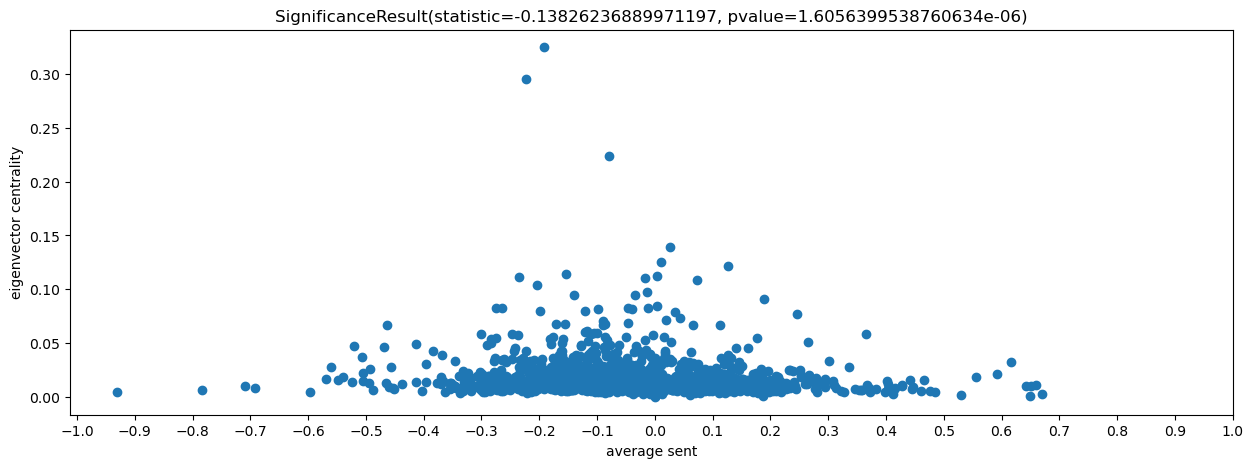

In [243]:
x='average sent'
y='eigenvector centrality'

plt.figure(figsize=(15,5))
plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
plt.xticks(np.arange(-1, 1.1, 0.1))
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

### Centrality vs Sentiment plot (averaging centralities in sentiment buckets)

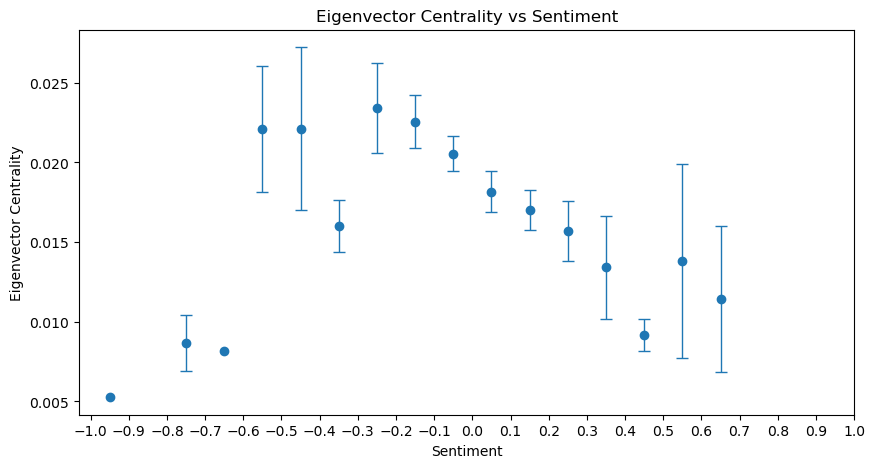

In [439]:
plt.figure(figsize=(10,5))

sentiment_buckets = np.arange(-1.0, 1.1, 0.1)
bucket_centralities = {bucket: [] for bucket in sentiment_buckets}

x = 'average sent'
y = 'eigenvector centrality'

datapoints = [(row[x], row[y]) for _, row in df_c.iterrows()]

# Group data points into sentiment buckets
for sentiment, centrality in datapoints:
    for i in range(len(sentiment_buckets) - 1):
        if sentiment_buckets[i] <= sentiment < sentiment_buckets[i + 1]:
            bucket_centralities[sentiment_buckets[i]].append(centrality)
            break

# Calculate average centralities, standard errors, and sentiment midpoints
average_centralities = []
std_errors = []
sentiment_midpoints = []

for bucket, centralities in bucket_centralities.items():
    if centralities:
        avg_centrality = np.mean(centralities)
        std_error = np.std(centralities, ddof=1) / np.sqrt(len(centralities))
        average_centralities.append(avg_centrality)
        std_errors.append(std_error)
        sentiment_midpoints.append(bucket + 0.05)  # Midpoint of the bucket

# Plotting with horizontal lines as error bars
plt.errorbar(
    sentiment_midpoints,
    average_centralities,
    # xerr=0.05,  # Set the width of the horizontal error bars
    yerr=std_errors,
    fmt='o',
    # color='b',  # Color of data points
    capsize=4,  # Size of the caps at the ends of error bars
    elinewidth=1,  # Line width of the horizontal error bars
    markeredgewidth=1,  # Line width of the marker edge
    markersize=6,  # Size of the data point markers
)

plt.xlabel('Sentiment')
plt.ylabel('Eigenvector Centrality')
plt.title('Eigenvector Centrality vs Sentiment')
plt.xticks(np.arange(-1.0, 1.1, 0.1))
plt.savefig('./saves/cent vs sent.svg', format='svg')
plt.show()

In [418]:
df_c['influence'] = df_c['eigenvector centrality'] * np.log1p(df_c['followers'])

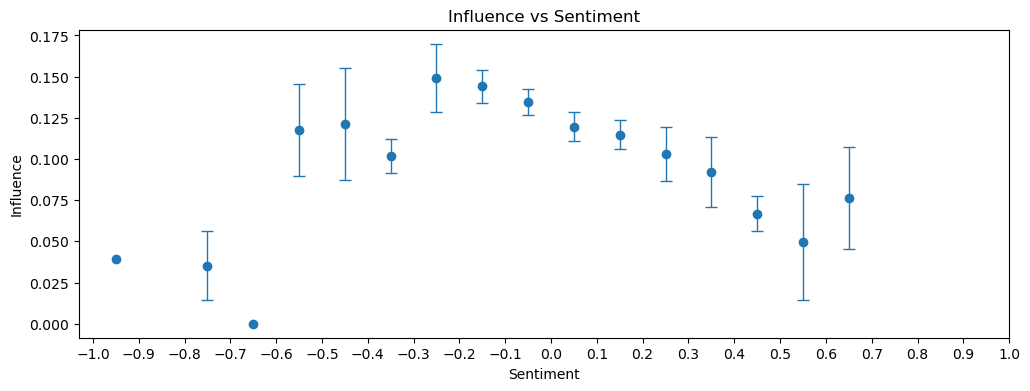

In [443]:
plt.figure(figsize=(12,4))

sentiment_buckets = np.arange(-1.0, 1.1, 0.1)
bucket_centralities = {bucket: [] for bucket in sentiment_buckets}

x='average sent'
y='influence'

datapoints = [(row[x], row[y]) for index, row in df_c.iterrows()]


# Group data points into sentiment buckets
for sentiment, centrality in datapoints:
    for i in range(len(sentiment_buckets) - 1):
        if sentiment_buckets[i] <= sentiment < sentiment_buckets[i + 1]:
            bucket_centralities[sentiment_buckets[i]].append(centrality)
            break

# Plotting with horizontal lines as error bars
plt.errorbar(
    sentiment_midpoints,
    average_centralities,
    # xerr=0.05,  # Set the width of the horizontal error bars
    yerr=std_errors,
    fmt='o',
    # color='b',  # Color of data points
    capsize=4,  # Size of the caps at the ends of error bars
    elinewidth=1,  # Line width of the horizontal error bars
    markeredgewidth=1,  # Line width of the marker edge
    markersize=6,  # Size of the data point markers
)

plt.xlabel('Sentiment')
plt.ylabel('Influence')
plt.title('Influence vs Sentiment')
plt.xticks(np.arange(-1.0, 1.1, 0.1))
plt.savefig('./saves/infl vs sent.svg', format='svg')
plt.show()

### Centrality vs Follower Count

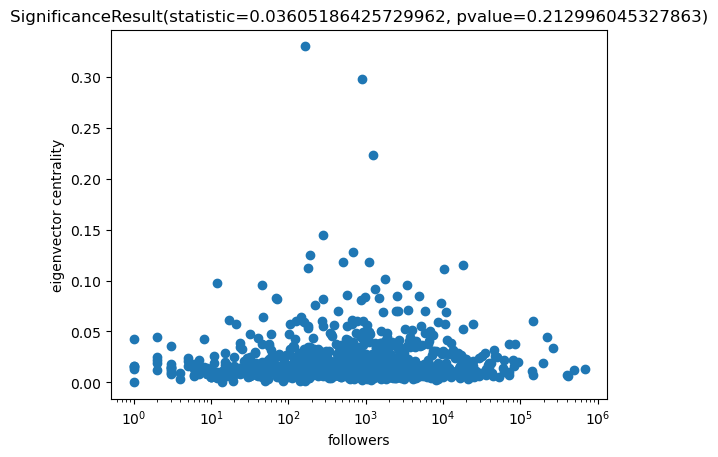

In [469]:
x='followers'
y='eigenvector centrality'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.xscale('log')
plt.show()

### Centrality vs Tweet Count

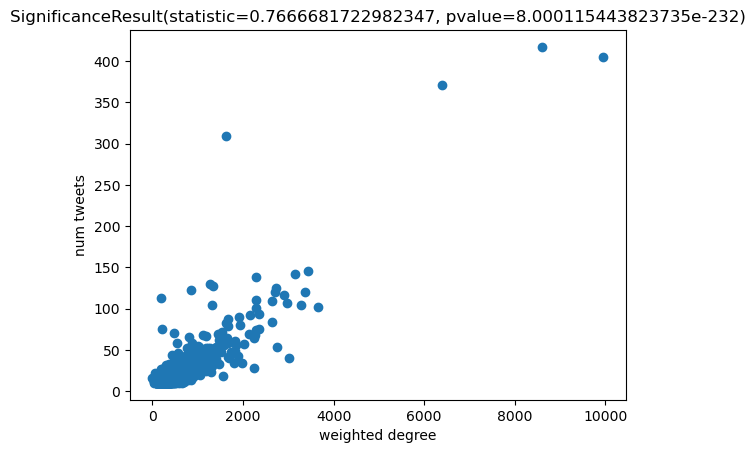

In [255]:
x='weighted degree'
y='num tweets'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

### Centrality vs Weighted Degree

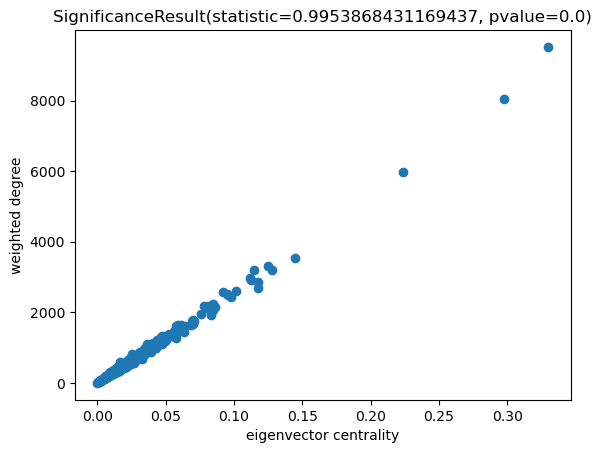

In [471]:
x='eigenvector centrality'
y='weighted degree'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

### Followers vs Tweet Count

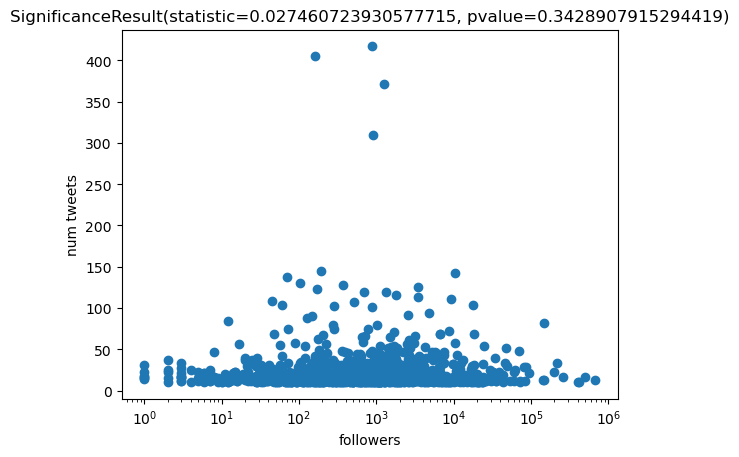

In [473]:
x='followers'
y='num tweets'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.xscale('log')
plt.show()

### Proportion of Strong Sentiment vs Followers/Centrality

In [457]:
df_c['num strong tweets'] = [len(df[(df['user_id'] == user) & (np.abs(df['sent']) >= 0.5) ]) for user in df_c['user']]
df_c['num negative tweets'] = [len(df[(df['user_id'] == user) & (df['sent'] <= -0.5) ]) for user in df_c['user']]
df_c['prop strong tweets'] = df_c['num strong tweets'] / df_c['num tweets']
df_c['prop negative tweets'] = df_c['num negative tweets'] / df_c['num tweets']

In [494]:
df_c.to_csv('user_network_black.csv', index=False)

In [5]:
df_c

user  eigenvector centrality  weighted degree  \
0                  721373                0.031068       810.192299   
1                  806585                0.013342       346.499668   
2                 5689592                0.006133       163.057839   
3                 6441732                0.018421       474.766180   
4                 7221022                0.022672       609.255259   
...                   ...                     ...              ...   
1190  1346992579523461120                0.005884       160.519059   
1191  1352268337338675200                0.004376       116.747892   
1192  1354677924704653312                0.022866       573.672381   
1193  1370092729573679104                0.005607       151.523712   
1194  1376775080168972288                0.001770        45.971589   

      num tweets  followers      screen name          prod  average sent  \
0             37        446         Swift818  3.613458e+05      0.055519   
1             20       3613      chris_mahan  1.251903e+06      0.163720   
2             10       7016             gank  1.144014e+06     -0.001600   
3             11       3975    KelaniNichole  1.887196e+06     -0.070873   
4             28       1335     fonziewonzie  8.133558e+05      0.250657   
...          ...        ...              ...           ...           ...   
1190          12         16     Bmo_The_Milf  2.568305e+03     -0.053717   
1191          12          0  CharlaneTrapan1  0.000000e+00     -0.009067   
1192          15        156  MichaelKinnard6  8.949289e+04     -0.504493   
1193          14          0      d0_The_m0sT  0.000000e+00     -0.691257   
1194          14        163      DiasporaNft  7.493369e+03      0.530579   

      num strong tweets  prop strong tweets  num negative tweets  \
0                    12            0.324324                    6   
1                     6            0.300000                    2   
2                     2            0.200000                    1   
3                     1            0.090909                    1   
4                    16            0.571429                    4   
...                 ...                 ...                  ...   
1190                  6            0.500000                    3   
1191                  1            0.083333                    0   
1192                 10            0.666667                   10   
1193                 10            0.714286                   10   
1194                  2            0.142857                    0   

      prop negative tweets  
0                 0.162162  
1                 0.100000  
2                 0.100000  
3                 0.090909  
4                 0.142857  
...                    ...  
1190              0.250000  
1191              0.000000  
1192              0.666667  
1193              0.714286  
1194              0.000000  

[1195 rows x 12 columns]

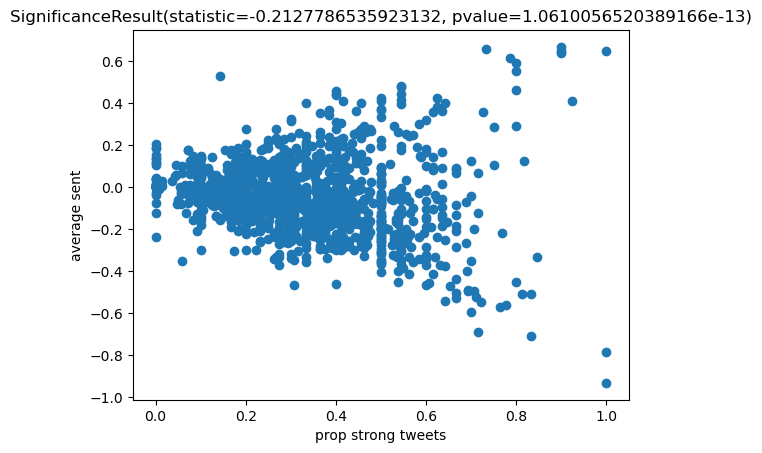

In [462]:
x='prop strong tweets'
y='average sent'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

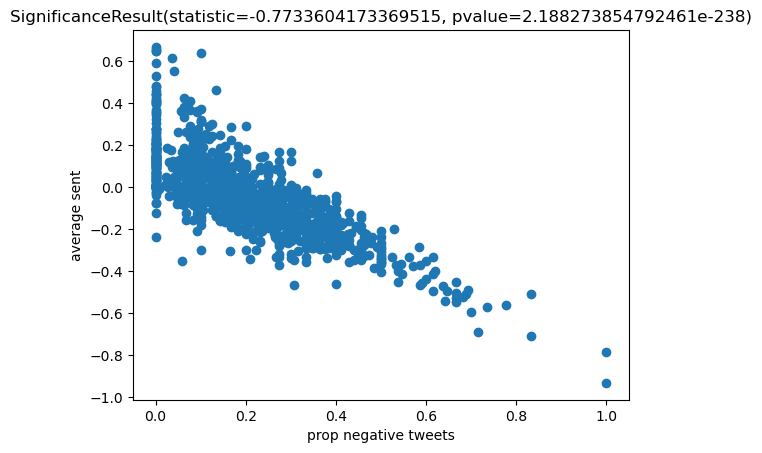

In [465]:
x='prop negative tweets'
y='average sent'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

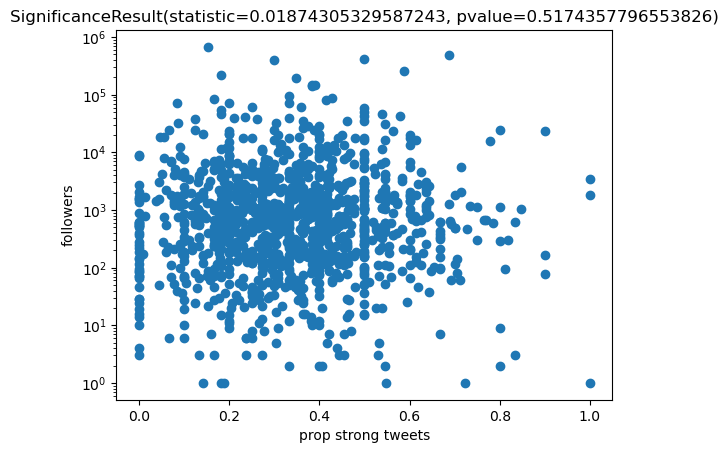

In [475]:
x='prop strong tweets'
y='followers'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.yscale('log')
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

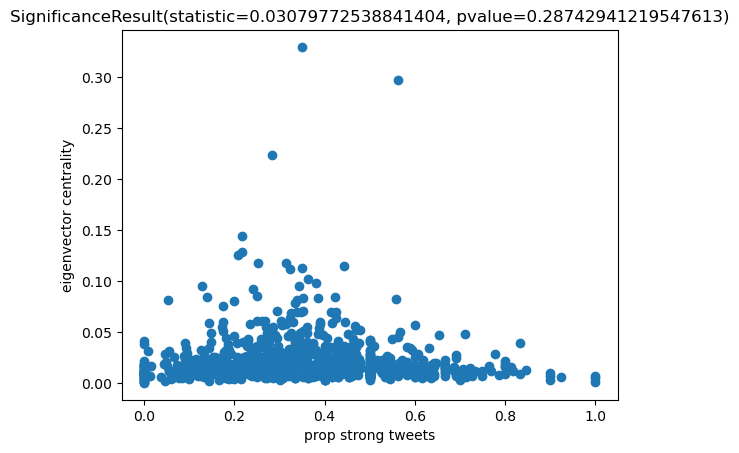

In [477]:
x='prop strong tweets'
y='eigenvector centrality'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

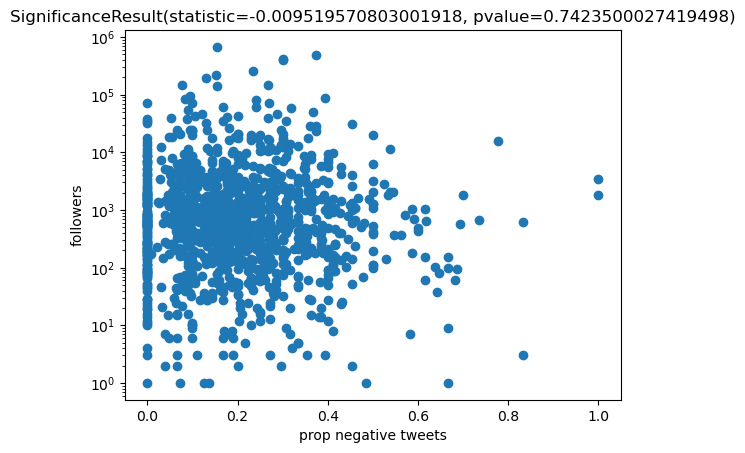

In [479]:
x='prop negative tweets'
y='followers'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
plt.yscale('log')
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

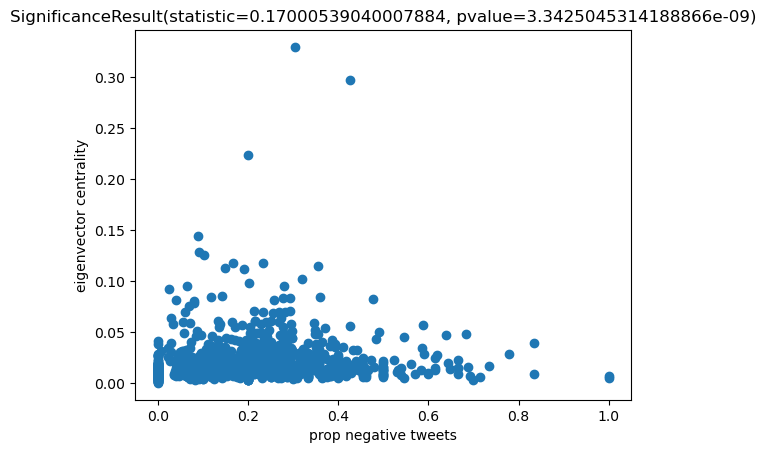

In [481]:
x='prop negative tweets'
y='eigenvector centrality'

plt.scatter(df_c[x], df_c[y])
plt.xlabel(x)
plt.ylabel(y)
spearman_corr = stats.spearmanr(df_c[x], df_c[y])
plt.title(spearman_corr)
plt.show()

## Plotting Centrality Change over Time for Top 5 Users, monthly

In [117]:
top_5_users = df_c.sort_values(by='eigenvector centrality', ascending=False).iloc[:5]

In [118]:
top_5_users

user  eigenvector centrality  weighted degree  num tweets  \
285    59047876                0.329947      9518.461504         405   
448   199120695                0.297871      8053.441088         417   
733  2185190036                0.223639      5967.849716         371   
453   205240369                0.144378      3537.263125         102   
574   473384312                0.128157      3208.616266         120   

     followers      screen name          prod  average sent  
285        163    sophiatseliem  1.551509e+06     -0.191473  
448        885     Nityalakshmi  7.127295e+06     -0.223182  
733       1254      mattlogical  7.483684e+06     -0.079958  
453        282   Progress_orDie  9.975082e+05      0.026492  
574        683  dandlionalchemy  2.191485e+06      0.010796

In [119]:
start_month = pd.Timestamp('2020-03')
end_month = pd.Timestamp('2021-06')
all_months = pd.period_range(start_month, end_month, freq='M')

In [20]:
path = './usersbymonth-black-5/user_network_'

user_centrs = {}

for user in list(top_5_users['user']):
    centrs = []
    for month in all_months:
        df_month = pd.read_csv(path + f'{month}.csv')
        try:
            centrs.append(df_month[df_month['user'] == user]['eigenvector centrality'].iloc[0])
        except:
            centrs.append(0)
    user_centrs[user] = centrs

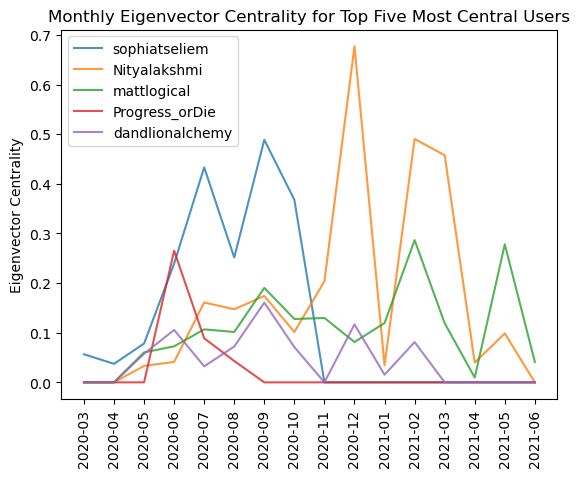

In [23]:
for user in user_centrs.keys():
    centrs = user_centrs[user]
    screen_name = df[df['user_id'] == user].iloc[0]['screen_name']
    plt.plot([str(month) for month in all_months], centrs, label=f'{screen_name}', alpha=0.8)

plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('Monthly Eigenvector Centrality for Top Five Most Central Users')
plt.legend()
plt.show()

### Analyzing one user

In [63]:
df.columns[:25]

Index(['created_at', 'tweet_id', 'text', 'in_reply_to_tweet_id',
       'in_reply_to_user_id', 'geo', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'lang', 'quoted_tweet_id',
       'possibly_sensitive', 'user_id', 'screen_name', 'followers_count',
       'friends_count', 'statuses_count', 'verified', 'hashtags', 'mentions',
       'date', '0', '1', '2'],
      dtype='object')

In [68]:
sophia = df[df['user_id'] == 59047876][['text', 'date',  \
                                'followers_count', 'friends_count', 'statuses_count', 'verified']]
sophia['date'] = pd.to_datetime(sophia['date'])

In [112]:
grouped = sophia.groupby(sophia['date'].dt.to_period('M')).agg({'followers_count': 'sum', 'date': 'count'})

# Calculate average follower count for each month
grouped['average_follower_count'] = grouped['followers_count'] / grouped['date']

In [113]:
grouped

followers_count  date  average_follower_count
date                                                  
2020-03            981.0     6              163.500000
2020-04           2346.0    14              167.571429
2020-05           3064.0    18              170.222222
2020-06          15753.0    90              175.033333
2020-07          15069.0    86              175.220930
2020-08          11119.0    63              176.492063
2020-09          14546.0    81              179.580247
2020-10           8027.0    45              178.377778
2020-11            355.0     2              177.500000

In [82]:
folls = grouped['average_follower_count'][:-1]
centrs = user_centrs[59047876][:8]

In [83]:
folls_diff = [folls[i] - folls[i-1] for i in range(1, len(folls))]
centrs_diff = [centrs[i] - centrs[i-1] for i in range(1, len(centrs))]

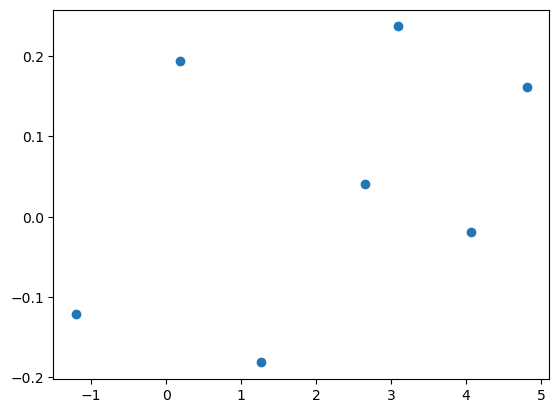

In [84]:
plt.scatter(folls_diff, centrs_diff)

In [62]:
centrs_diff, folls_diff

([0.007967698209236797,
  0.1197743586637432,
  -0.013703374125870582,
  0.026886124524793775,
  -0.07264199714482289,
  0.1023916021304683,
  0.473141362910695,
  -0.6426434155368641,
  0.45606852240334894,
  -0.032812553311029946,
  -0.41779266353946065,
  0.058809165439986905],
 [-5.157142857142844,
  8.728110599078377,
  25.52903225806449,
  18.762162162162213,
  8.943100995732493,
  1.0447368421052943,
  12.38846153846157,
  3.366300366300379,
  -2.1666666666667425,
  26.72208175305525,
  59.499006682318964,
  -1.059183673469306])

In [61]:
centrs

[0.033202068204042,
 0.0411697664132788,
 0.160944125077022,
 0.1472407509511514,
 0.1741268754759452,
 0.1014848783311223,
 0.2038764804615906,
 0.6770178433722855,
 0.0343744278354214,
 0.4904429502387703,
 0.4576303969277404,
 0.0398377333882797,
 0.0986468988282666]

In [90]:
user_df = df[df['user_id'] == 59047876]
user_df['date'] = pd.to_datetime(user_df['date'])

/var/folders/qj/xk2kpqqd6cqb4q976yfqswf00000gn/T/ipykernel_1515/220539594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['date'] = pd.to_datetime(user_df['date'])


In [91]:
user_df

created_at      tweet_id  \
1      2020-03-11 12:46:50  1.237722e+18   
2      2020-03-11 12:47:00  1.237722e+18   
219    2020-03-15 15:32:54  1.239213e+18   
285    2020-03-16 20:35:58  1.239652e+18   
883    2020-03-22 08:26:35  1.241642e+18   
...                    ...           ...   
57162  2020-10-30 19:39:42  1.322262e+18   
57163  2020-10-30 19:40:41  1.322262e+18   
57164  2020-10-30 19:41:05  1.322262e+18   
57290  2020-11-01 02:01:17  1.322720e+18   
57574  2020-11-03 04:18:15  1.323480e+18   

                                                    text  \
1      change:  new border wall blocks 90% of illegal...   
2      new border wall blocks 90% of illegal crossing...   
219    beware the ides of march:  on the 15th day of ...   
285    jeff dunetz: why is rep. clyburn (d-sc) allowe...   
883    chinese virus is chinese:  yes, the virus came...   
...                                                  ...   
57162  godwin alert: disgusting! biden-harris uses hi...   
57163  instapundit » home for hate: blm rioters tell ...   
57164  blm rioters tell jewish men trying to show ‘so...   
57290  flashback:  when black lives matter to democra...   
57574  is it trump or biden that has an anti-semitism...   

       in_reply_to_tweet_id  in_reply_to_user_id  geo  quote_count  \
1                       NaN                  NaN  NaN          0.0   
2                       NaN                  NaN  NaN          0.0   
219                     NaN                  NaN  NaN          0.0   
285                     NaN                  NaN  NaN          0.0   
883                     NaN                  NaN  NaN          0.0   
...                     ...                  ...  ...          ...   
57162                   NaN                  NaN  NaN          0.0   
57163                   NaN                  NaN  NaN          0.0   
57164                   NaN                  NaN  NaN          0.0   
57290                   NaN                  NaN  NaN          0.0   
57574                   NaN                  NaN  NaN          0.0   

       reply_count  retweet_count  favorite_count  ...       262       263  \
1              0.0            0.0             0.0  ...  0.000588  0.000453   
2              0.0            0.0             0.0  ...  0.000893  0.000687   
219            0.0            0.0             0.0  ...  0.000766  0.000518   
285            0.0            0.0             0.0  ...  0.000851  0.000567   
883            0.0            0.0             0.0  ...  0.001091  0.000879   
...            ...            ...             ...  ...       ...       ...   
57162          0.0            0.0             0.0  ...  0.002972  0.001671   
57163          0.0            0.0             0.0  ...  0.002361  0.001557   
57164          0.0            0.0             0.0  ...  0.002292  0.001510   
57290          0.0            0.0             0.0  ...  0.001672  0.001978   
57574          0.0            0.0             0.0  ...  0.001452  0.000950   

            264       265       266       267       268       269  topics  \
1      0.000727  0.000537  0.000435  0.000541  0.000583  0.000412      65   
2      0.001104  0.000815  0.000660  0.000822  0.000885  0.000625      65   
219    0.146467  0.000614  0.000465  0.000609  0.000644  0.000654      -1   
285    0.004275  0.000686  0.000499  0.000665  0.000670  0.000746      24   
883    0.001188  0.001086  0.000811  0.000981  0.000915  0.000921      16   
...         ...       ...       ...       ...       ...       ...     ...   
57162  0.000562  0.002918  0.001421  0.003458  0.001740  0.000681      -1   
57163  0.006943  0.001920  0.001346  0.001827  0.001728  0.002054      79   
57164  0.006676  0.001864  0.001305  0.001773  0.001676  0.001994      79   
57290  0.000912  0.001512  0.002050  0.002021  0.001890  0.001098     112   
57574  0.003033  0.001184  0.000811  0.001117  0.001018  0.001252      10   

         sent  
1     -0.6705  
2     -0.6705  
219    0.0000  

In [108]:
counts = user_df.resample('2W', on='date').size().reset_index(name='tweet_count')

In [109]:
counts

date  tweet_count
0  2020-03-15            3
1  2020-03-29            2
2  2020-04-12            9
3  2020-04-26            6
4  2020-05-10            6
5  2020-05-24            4
6  2020-06-07           22
7  2020-06-21           38
8  2020-07-05           63
9  2020-07-19           40
10 2020-08-02           26
11 2020-08-16           23
12 2020-08-30           35
13 2020-09-13           42
14 2020-09-27           35
15 2020-10-11           23
16 2020-10-25           16
17 2020-11-08           12

## Plotting Centrality change over Time for Top 5 users, biweekly

In [1031]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

In [291]:
path = './usersby2w-black-5/user_network_'

user_centrs = {}

for user in tqdm(list(df_c['user'])):
    centrs = []
    for date in biweekly_dates[:-1]:
        df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
        try:
            centrs.append(df_date[df_date['user'] == user]['eigenvector centrality'].iloc[0])
        except:
            centrs.append(0)
    user_centrs[user] = centrs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1195/1195 [00:37<00:00, 32.07it/s]


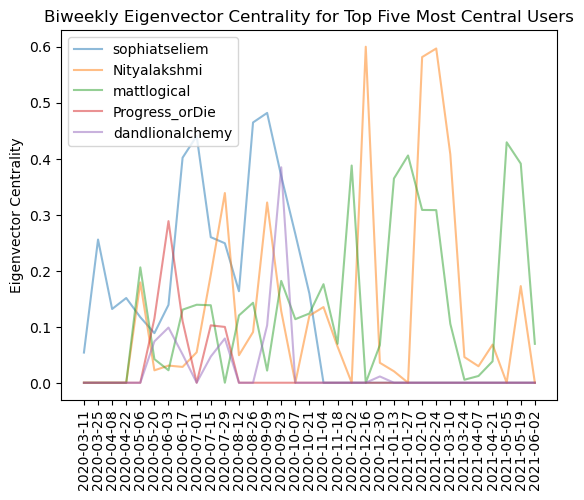

In [132]:
for user in user_centrs.keys():
    centrs = user_centrs[user]
    screen_name = df[df['user_id'] == user].iloc[0]['screen_name']
    plt.plot([str(date)[:10] for date in biweekly_dates[:-1]], centrs, label=f'{screen_name}', alpha=0.5)

plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('Biweekly Eigenvector Centrality for Top Five Most Central Users')
plt.legend()
plt.show()

## Plotting Centrality change over Time for Top 5 users, biweekly, among users who tweeted 10+ times

In [7]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

In [8]:
path = './usersby2w-black/user_network_'

user_centrs = {}
user_degrees = {}

for user in tqdm(list(df_c['user'])):
    centrs = []
    degrees = []
    for date in biweekly_dates[:-1]:
        df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
        try:
            centrs.append(df_date[df_date['user'] == user]['eigenvector centrality'].iloc[0])
            degrees.append(df_date[df_date['user'] == user]['weighted degree'].iloc[0])
        except:
            centrs.append(np.nan)
            degrees.append(np.nan)
    user_centrs[user] = centrs 
    user_degrees[user] = degrees

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1195/1195 [00:57<00:00, 20.67it/s]


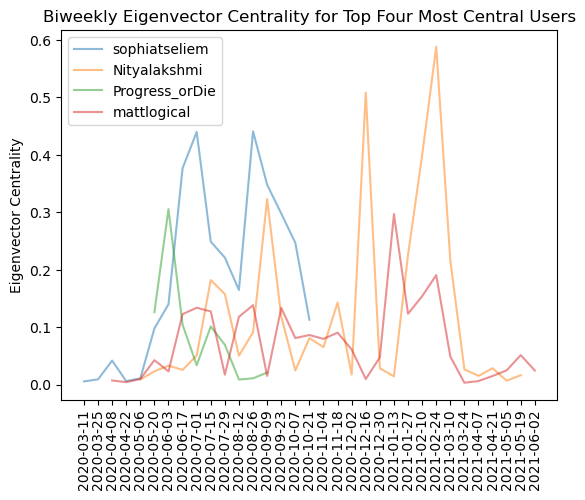

In [941]:
for user in user_centrs.keys():
    if user in list(top_5_users['user'][:4]):
        centrs = user_centrs[user]
        screen_name = df[df['user_id'] == user].iloc[0]['screen_name']
        plt.plot([str(date)[:10] for date in biweekly_dates[:-1]], centrs, label=f'{screen_name}', alpha=0.5)

plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('Biweekly Eigenvector Centrality for Top Four Most Central Users')
plt.legend()
plt.show()

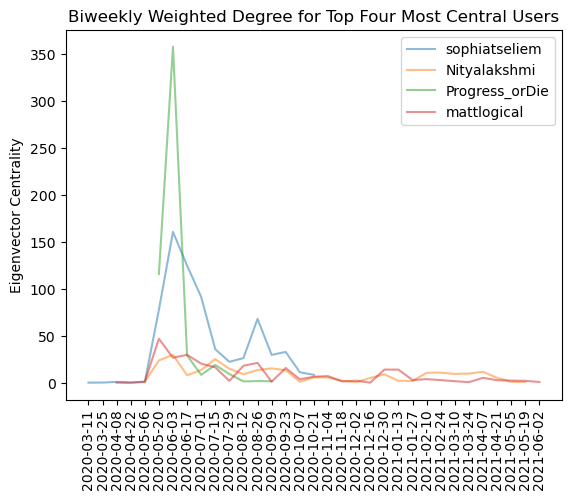

In [1022]:
for user in user_centrs.keys():
    if user in list(top_5_users['user'][:4]):
        centrs = user_degrees[user]
        screen_name = df[df['user_id'] == user].iloc[0]['screen_name']
        plt.plot([str(date)[:10] for date in biweekly_dates[:-1]], centrs, label=f'{screen_name}', alpha=0.5)

plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('Biweekly Weighted Degree for Top Four Most Central Users')
plt.legend()
plt.show()

## Centrality over time

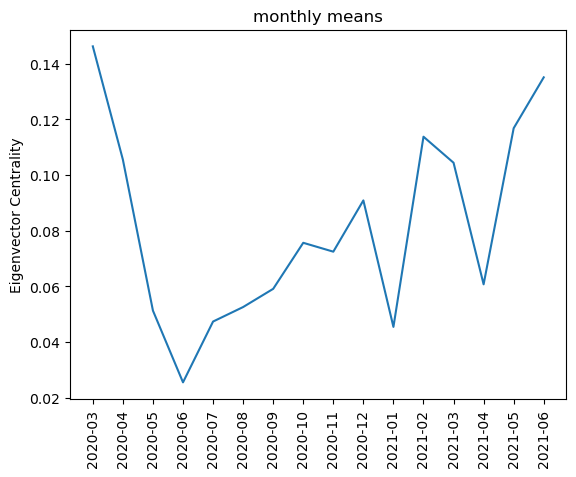

In [155]:
path = './usersbymonth-black-5/user_network_'
avgs = []

for month in all_months:
    df_month = pd.read_csv(path + f'{month}.csv')
    avgs.append(np.mean(df_month['eigenvector centrality']))
plt.plot([str(month) for month in all_months], avgs)
plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('monthly means')
plt.show()

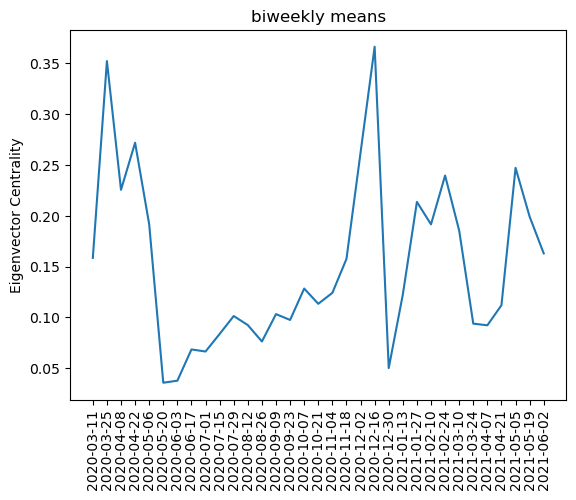

In [158]:
path = './usersby2w-black-5/user_network_'
avgs = []

for date in biweekly_dates[:-1]:
    df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
    avgs.append(np.mean(df_date['eigenvector centrality']))
plt.plot([str(date)[:10] for date in biweekly_dates[:-1]], avgs)
plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('biweekly means')
plt.show()

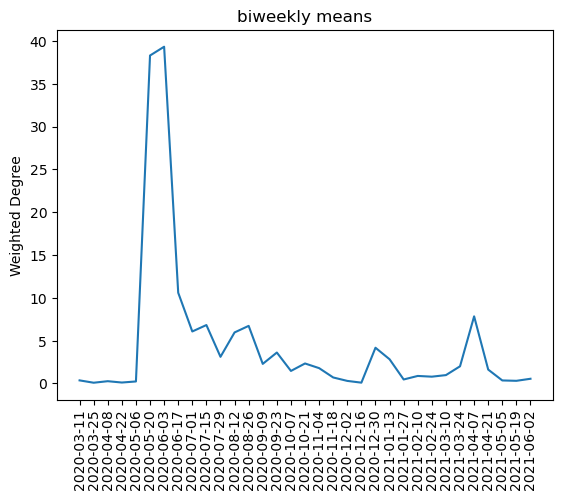

In [306]:
path = './usersby2w-black-5/user_network_'
avgs = []

for date in biweekly_dates[:-1]:
    df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
    avgs.append(np.mean(df_date['weighted degree']))
plt.plot([str(date)[:10] for date in biweekly_dates[:-1]], avgs)
plt.xticks(rotation=90)
plt.ylabel('Weighted Degree')
plt.title('biweekly means')
plt.show()

Mean for centrality is not as accurate... it is always normalized (to something like between 0 and 1) so mean centrality will dip if there are more users. Meanwhile the weighted degree mean is more accurate because in general, weighted degrees increase with more users tweeting that biweek. So the average will increase.

So it's misleading to plot correlation between centrality and weighted degree. Because it will always be nice correlation, but the values of centrality will always be around the same in each biweek while degree jumps around depending on how many users tweeted.

More accurate would be to sum the eigenvector centrality

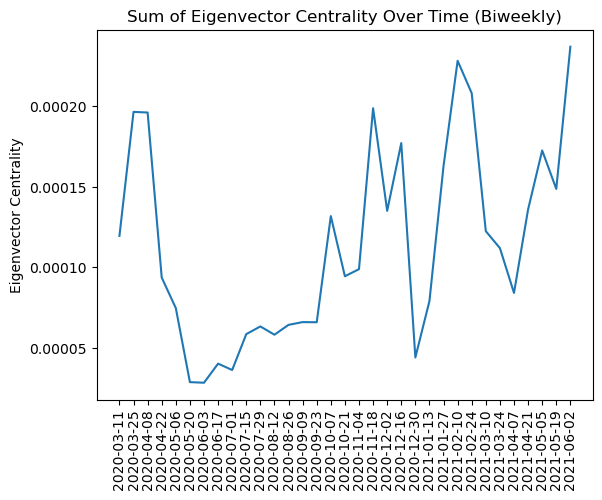

In [263]:
path = './usersby2w-black/user_network_'
avgs = []

for date in biweekly_dates[:-1]:
    df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
    avgs.append(np.sum(df_date['eigenvector centrality']) / len(df_date)**2)
plt.plot([str(date)[:10] for date in biweekly_dates[:-1]], avgs)
plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('Sum of Eigenvector Centrality Over Time (Biweekly)')
plt.show()

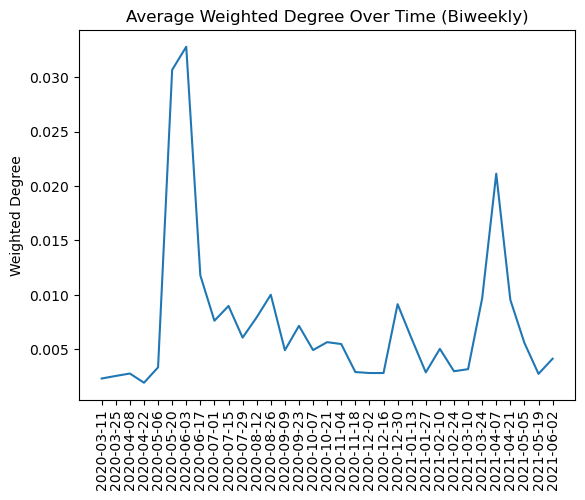

In [259]:
path = './usersby2w-black/user_network_'
avgs = []

for date in biweekly_dates[:-1]:
    df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
    avgs.append(np.mean(df_date['weighted degree']) / len(df_date))
plt.plot([str(date)[:10] for date in biweekly_dates[:-1]], avgs)
plt.xticks(rotation=90)
plt.ylabel('Weighted Degree')
plt.title('Average Weighted Degree Over Time (Biweekly)')
plt.show()

In [610]:
path = './usersby2w-black/user_network_'
l=[]

for date in biweekly_dates[:-1]:
    df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
    centr = df_date['eigenvector centrality']
    degrees = df_date['weighted degree']
    spearman_corr, p = stats.spearmanr(centr, degrees)
    l.append(spearman_corr)

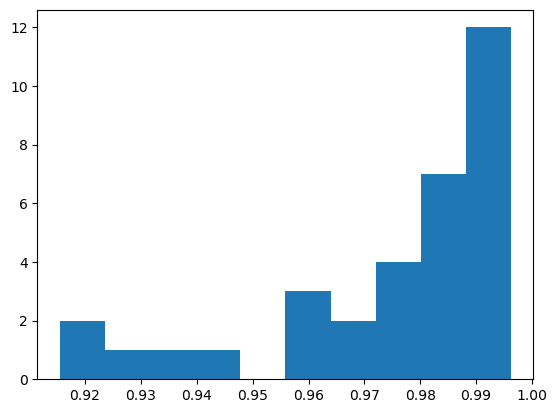

In [611]:
plt.hist(l)
plt.show()

## Analyzing engagement

### Define get_engagements

In [684]:
def get_engagements(user_id):
    df_user = df[df['user_id'] == user_id][['text', 'date',  \
                                'followers_count', 'friends_count', 'statuses_count', 'sent']]
    df_user['date'] = pd.to_datetime(df_user['date'])
    
    dfs_by_2w = {}
    for i in range(len(biweekly_dates)-1):
        start = biweekly_dates[i]
        end = biweekly_dates[i + 1]
        dfs_by_2w[start] = df_user[(df_user['date'] >= start) & (df_user['date'] <= end)]
        
    avg_folls=[]
    avg_friends=[]
    avg_statuses=[]
    avg_sents = []
    for date in biweekly_dates[:-1]:
        df_s = dfs_by_2w[date]
        avg_folls.append(np.sum(df_s['followers_count']) / len(df_s))
        avg_friends.append(np.sum(df_s['friends_count']) / len(df_s))
        avg_statuses.append(np.sum(df_s['statuses_count']) / len(df_s))
        avg_sents.append(np.sum(df_s['sent']) / len(df_s))
        
    return avg_folls, avg_friends, avg_statuses, avg_sents

### Average sentiment over time for most central users

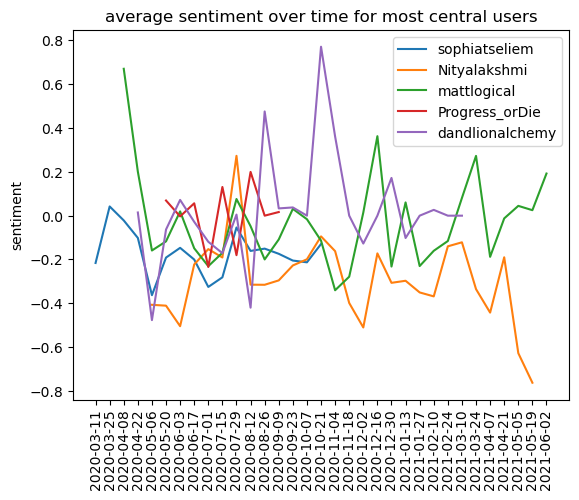

In [251]:
for user in list(top_5_users['user']):
    _,_,_,avg_sents = get_engagements(user)
    plt.plot([str(date)[:10] for date in biweekly_dates[:-1]], avg_sents, label=top_5_users[top_5_users['user'] == user]['screen name'].iloc[0])
    
plt.xticks(rotation=90)
plt.ylabel('sentiment')
plt.title('average sentiment over time for most central users')
plt.legend()
plt.show()

### Plotting Function

In [151]:
def plot(lists, labels):
    n=len(lists)
    k=2.4*n
    fig, axes = plt.subplots(n, n, figsize=(k,k))
    for i in range(n):
        for j in range(n):
            if i == j:
                axes[i, j].axis('off')  # No need to plot diagonal
            else:
                x = lists[i]
                y = lists[j]
                axes[i, j].scatter(x, y)
                correlation, _ = stats.spearmanr(x, y)
                axes[i, j].set_title(f"Correlation: {correlation:.4f}")
                axes[i, j].set_xlabel(labels[i])
                axes[i, j].set_ylabel(labels[j])

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [152]:
def plot2(lists, labels):
    n = len(lists)
    correlations = np.zeros((n, n))  # To store the correlations

    # Calculate the correlations between lists
    for i in range(n):
        for j in range(n):
            if i != j:
                correlation, _ = stats.spearmanr(lists[i], lists[j])
                correlations[i, j] = correlation

    # Create a heatmap of the correlations with x labels on top
    fig, ax = plt.subplots(figsize=(n, 0.8*n))
    heatmap = sns.heatmap(correlations, annot=True, cmap="viridis", square=True,
                xticklabels=labels, yticklabels=labels, ax=ax)

    # Move x-axis labels to the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    heatmap.set_xticklabels(labels, rotation=90)

    plt.title("Correlation Heatmap")
    plt.show()
    return fig

### Sophia

In [857]:
user_id = 59047876
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents = get_engagements(user_id)

In [858]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])

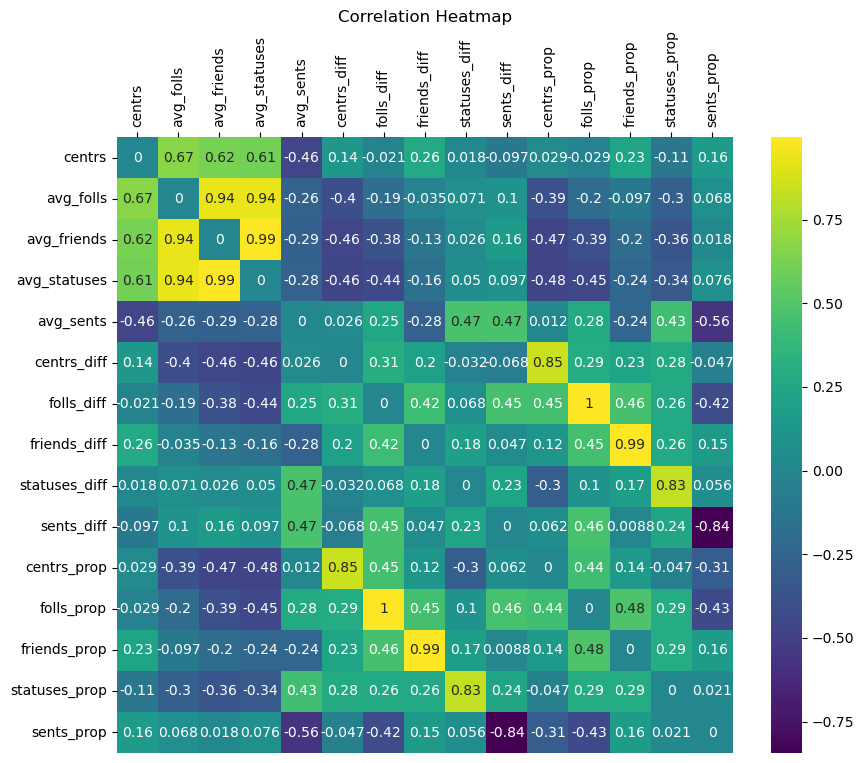

In [859]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, centrs_prop, 
         folls_prop, friends_prop, statuses_prop, sents_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop']

plot2(lists, labels)

In [848]:
# plt.plot(centrs)
# plt.plot(avg_folls)
# plt.plot(avg_friends)
# plt.plot(avg_statuses)
# plt.plot(avg_sents)
# plt.show()

### Nit

In [856]:
user_id = 199120695
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents = get_engagements(user_id)

In [853]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])

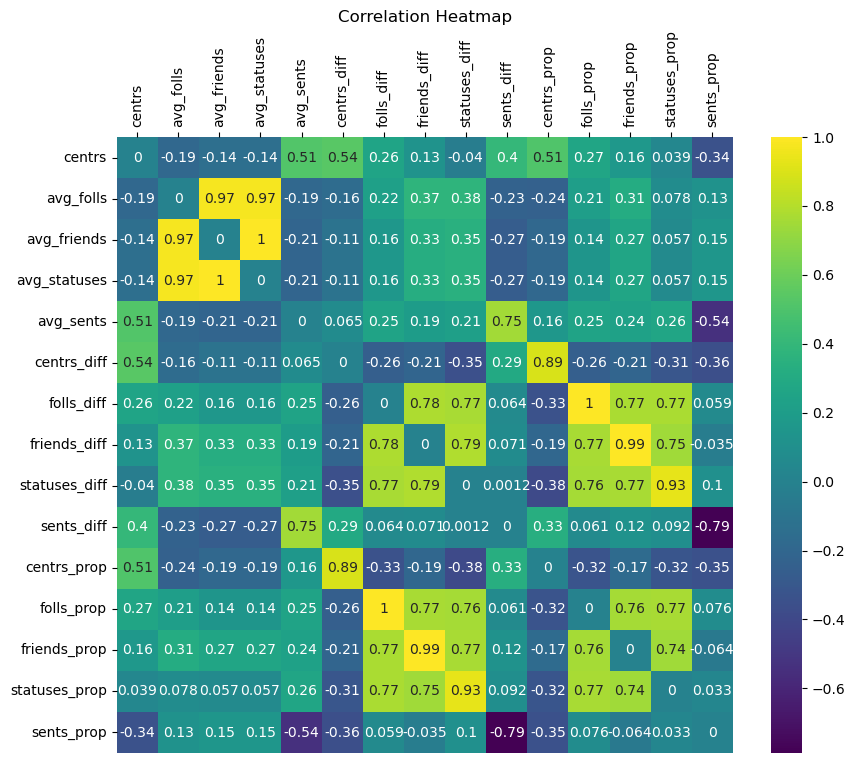

In [854]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, centrs_prop, 
         folls_prop, friends_prop, statuses_prop, sents_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop']

plot2(lists, labels)

In [778]:
# plt.plot(centrs)
# plt.plot(avg_folls)
# plt.plot(avg_friends)
# plt.plot(avg_statuses)
# plt.plot(avg_sents)
# plt.plot(centrs_diff)
# plt.plot(folls_diff)
# plt.plot(friends_diff)
# plt.plot(statuses_diff)
# plt.plot(sents_diff)
# plt.show()

### Matt

In [835]:
user_id = 2185190036
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents = get_engagements(user_id)

In [838]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])

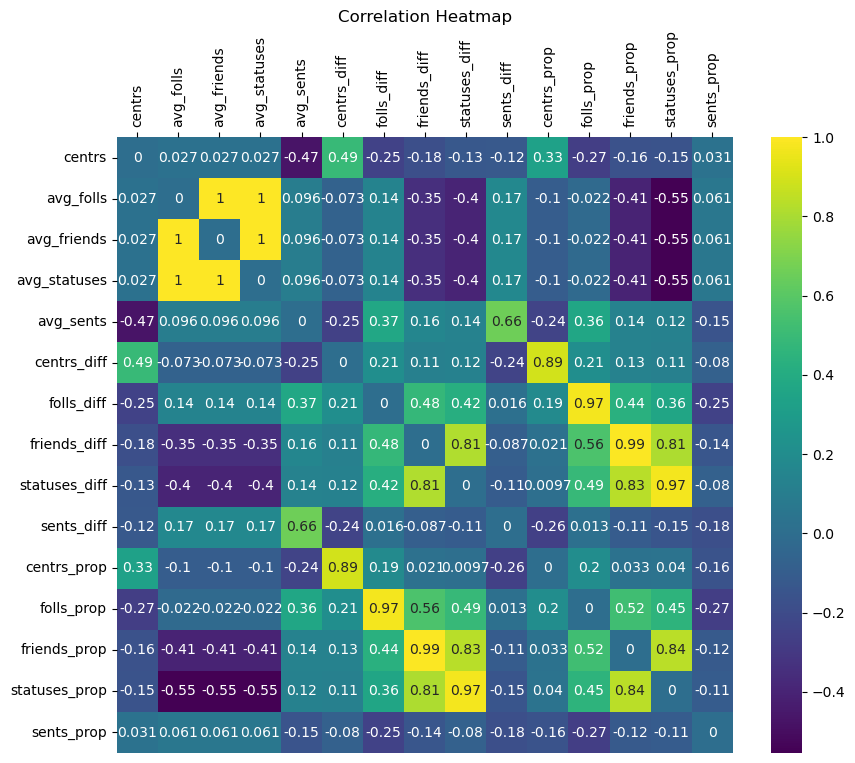

In [839]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, centrs_prop, 
         folls_prop, friends_prop, statuses_prop, sents_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop']

plot2(lists, labels)

### Progress

In [831]:
user_id = 205240369
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents = get_engagements(user_id)

In [832]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])

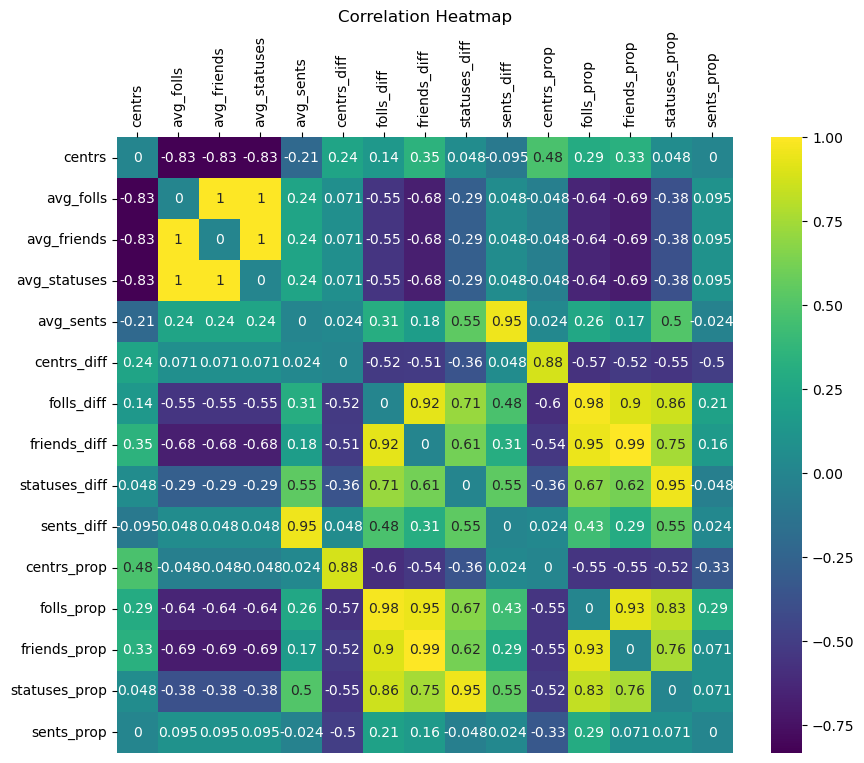

In [833]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, centrs_prop, 
         folls_prop, friends_prop, statuses_prop, sents_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop']

plot2(lists, labels)

## Spearman Corr for Average __? vs Average Centrality over time

Only including users from the 1195 who appear in at least __ of the biweekly dataframes we've created (i.e. have tweeted at least 5 times in separate biweeks)

In [431]:
df_c2 = pd.DataFrame(columns=df_c.columns)

path = './usersby2w-black/user_network_'

for index, row in tqdm(df_c.iterrows()):
    count = 0
    for date in biweekly_dates[:-1]:
        df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
        
        if row['user'] in list(df_date['user']):
            # print('here')
            count += 1
            
    if count >= 5:
        df_c2 = pd.concat([df_c2, pd.DataFrame([row])], ignore_index=True)

1195it [00:37, 31.56it/s]


In [433]:
len(df_c2)

928

Average followers vs centrality

In [434]:
spearman_coeffs = {}
for user in tqdm(list(df_c2['user'])):
    avg_folls,_,_,_ = get_engagements(user)
    centrs = user_centrs[user]
    
    avg_folls, centrs = np.array(avg_folls), np.array(centrs)
    
    not_nan = ~np.isnan(avg_folls)

    avg_folls = avg_folls[not_nan]
    centrs = centrs[not_nan]
    
    spearman_corr, p = stats.spearmanr(avg_folls, centrs)
    spearman_coeffs[user] = spearman_corr

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 928/928 [00:17<00:00, 53.19it/s]


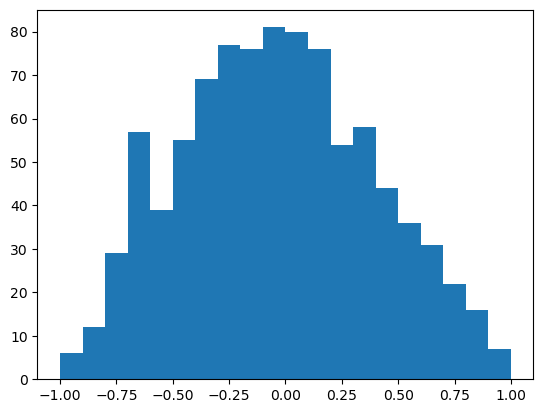

In [435]:
plt.hist(spearman_coeffs.values(), bins=20)
plt.show()

Average follower difference vs centrality difference

In [436]:
spearman_coeffs = {}
for user in tqdm(list(df_c2['user'])):
    avg_folls,_,_,_ = get_engagements(user)
    centrs = user_centrs[user]
    
    avg_folls=np.diff(avg_folls)
    centrs=np.diff(centrs)
    
    avg_folls = np.array(avg_folls)
    centrs = np.array(centrs)
    
    not_nan = ~np.isnan(avg_folls)

    avg_folls = avg_folls[not_nan]
    centrs = centrs[not_nan]
    
    spearman_corr, p = stats.spearmanr(avg_folls, centrs)
    spearman_coeffs[user] = spearman_corr

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 928/928 [00:17<00:00, 54.45it/s]


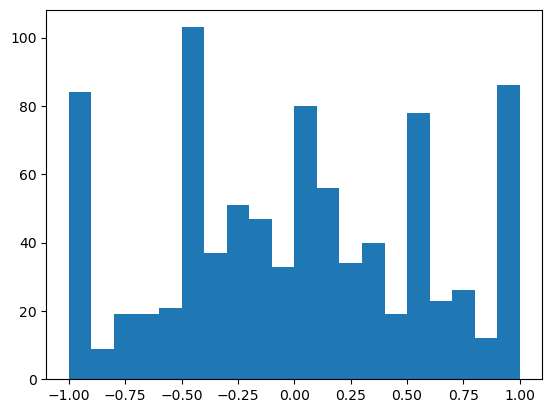

In [437]:
plt.hist(spearman_coeffs.values(), bins=20)
plt.show()

In [438]:
for user, corr in spearman_coeffs.items():
    if np.abs(corr) >= 0.6:
        print(user, corr)

11006752 -0.6666937223947136
11770332 0.9486832980505139
13575602 0.9999999999999999
14073855 -1.0
14414844 1.0
14719297 0.9999999999999999
14782218 -1.0
15119466 -0.9999999999999999
15292827 -1.0
15393848 -0.6708203932499368
15798812 0.9999999999999999
15950185 -1.0
16523618 1.0
16563793 -0.8660254037844387
16637169 -1.0
16668251 -0.6
16716641 0.9999999999999999
16746580 -1.0
16810949 -0.6
16876498 0.9999999999999999
16910759 0.7999999999999999
17414054 -0.9999999999999999
17595258 -1.0
17681644 -0.9999999999999999
17741022 -0.7999999999999999
18039285 0.9999999999999999
20362089 0.6667366910003157
20564407 -0.9999999999999999
20962039 -0.6071428571428572
21017269 -0.9999999999999999
21394805 0.6785714285714287
21579353 -0.632455532033676
21843799 -0.9999999999999999
21983615 0.7
22664654 -0.9999999999999999
22988702 0.642857142857143
23374944 1.0
24061160 0.9999999999999999
24803367 -0.6000000000000001
24934572 0.7999999999999999
25203689 -0.9999999999999999
25324974 -0.9999999999999

Average follower difference proportion vs centrality difference proportion

In [411]:
spearman_coeffs = {}
for user in tqdm(list(df_c2['user'])):
    avg_folls,_,_,_ = get_engagements(user)
    centrs = user_centrs[user]
    
    avg_folls = np.array(avg_folls)
    centrs = np.array(centrs)
    
    not_nan = ~np.isnan(avg_folls)
    avg_folls = avg_folls[not_nan]
    centrs = centrs[not_nan]
    
    avg_folls = np.diff(avg_folls) / avg_folls[1:]
    centrs = np.diff(centrs) / centrs[1:]
    
    spearman_corr, p = stats.spearmanr(avg_folls, centrs)
    spearman_coeffs[user] = spearman_corr
    print(spearman_corr)

 21%|████████████████████████▎                                                                                          | 11/52 [00:00<00:00, 50.37it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.26347777762091695
0.44705882352941173
nan


 56%|████████████████████████████████████████████████████████████████▏                                                  | 29/52 [00:00<00:00, 54.32it/s]

-0.028988551782622423
nan
0.42073952899018185
nan
0.7142857142857143
-0.06246201967198868
nan
nan
-0.43482827673933633
nan
nan
nan
nan
nan
nan
nan
nan


 79%|██████████████████████████████████████████████████████████████████████████████████████████▋                        | 41/52 [00:00<00:00, 55.20it/s]

nan
nan
nan
nan
nan
nan
nan
-0.9999999999999999
nan
nan
nan
nan
nan
nan


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 54.61it/s]

nan
nan
nan
-0.2380952380952381
nan
nan
nan
nan
nan


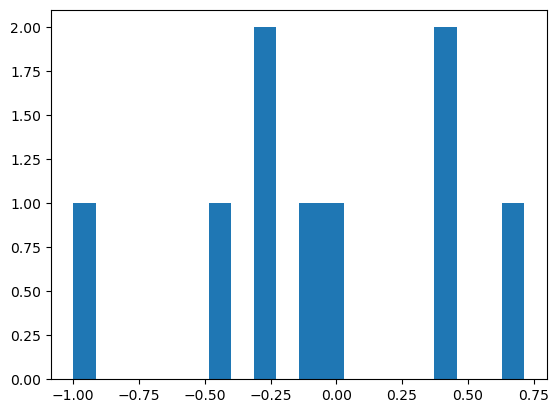

In [412]:
plt.hist(spearman_coeffs.values(), bins=20)
plt.show()

Average sentiment vs centrality

In [374]:
spearman_coeffs = {}
for user in tqdm(list(df_c['user'])):
    avg_folls,_,_,avg_sents = get_engagements(user)
    centrs = user_centrs[user]
    
    avg_sents, centrs = np.array(avg_sents), np.array(centrs)
    
    not_nan = ~np.isnan(avg_folls)

    avg_sents = avg_sents[not_nan]
    centrs = centrs[not_nan]
    
    spearman_corr, p = stats.spearmanr(avg_sents, centrs)
    spearman_coeffs[user] = spearman_corr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1195/1195 [00:20<00:00, 57.15it/s]


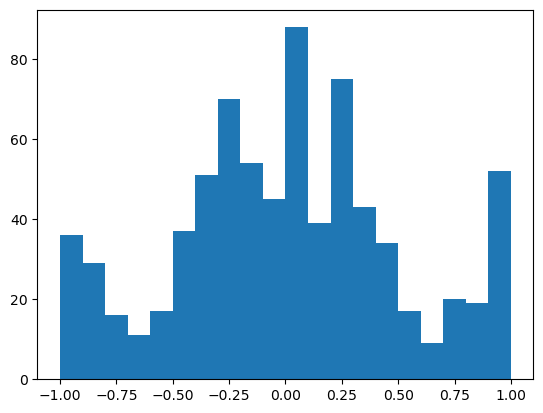

In [375]:
plt.hist(spearman_coeffs.values(), bins=20)
plt.show()

## Spearman Corr for Proportion/Number of Strong/Negative Tweets vs Difference Proportion of Followers / Centrality

Here, NUMBER of strong/negative tweets may be more important because the proportion may easily be 1 just because they tweet exactly one strong / negative tweet. Instead, the exact quantity may be more influential...?

### Adding num strong/negative tweet data to the biweekly partitioned user data

In [486]:
df['date'] = pd.to_datetime(df['date'])

In [538]:
path = './usersby2w-black/user_network_'

for i in tqdm(range(len(biweekly_dates)-1)):
    date = biweekly_dates[i]
    df_date = pd.read_csv(path + str(date)[:10] + '.csv')
    
    num_strong_tweets = []
    num_negative_tweets = []

    for user in list(df_date['user']):
        df_tweets = df[(df['user_id'] == user) & (df['date'] >= biweekly_dates[i]) & (df['date'] <= biweekly_dates[i + 1])]
        num_strong_tweets.append(len(df_tweets[(df_tweets['user_id'] == user) & (np.abs(df_tweets['sent']) >= 0.25)]))
        num_negative_tweets.append(len(df_tweets[(df_tweets['user_id'] == user) & (df_tweets['sent'] <= -0.25) ]))

    df_date['num strong tweets'] = num_strong_tweets
    df_date['num negative tweets'] = num_negative_tweets
    df_date['prop strong tweets'] = df_c['num strong tweets'] / df_c['num tweets']
    df_date['prop negative tweets'] = df_c['num negative tweets'] / df_c['num tweets']
    
    df_date.to_csv(path + str(date)[:10] + '.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.72it/s]


### Redefine get_engagements

In [139]:
def get_engagements(user_id):
    df_user = df[df['user_id'] == user_id][['text', 'date',  \
                                'followers_count', 'friends_count', 'statuses_count', 'sent']]
    df_user['date'] = pd.to_datetime(df_user['date'])
    
    dfs_by_2w = {}
    for i in range(len(biweekly_dates)-1):
        start = biweekly_dates[i]
        end = biweekly_dates[i + 1]
        dfs_by_2w[start] = df_user[(df_user['date'] >= start) & (df_user['date'] <= end)]
        
    avg_folls=[]
    avg_friends=[]
    avg_statuses=[]
    avg_sents = []
    num_strong_tweets = []
    num_negative_tweets = []
    prop_strong_tweets = []
    prop_negative_tweets = []
    
    for date in biweekly_dates[:-1]:
        df_s = dfs_by_2w[date]
        avg_folls.append(np.sum(df_s['followers_count']) / len(df_s))
        avg_friends.append(np.sum(df_s['friends_count']) / len(df_s))
        avg_statuses.append(np.sum(df_s['statuses_count']) / len(df_s))
        avg_sents.append(np.sum(df_s['sent']) / len(df_s))
        
        df_date = pd.read_csv(path + str(date)[:10] + '.csv')
        try:
            num_strong_tweets.append(df_date[df_date['user'] == user_id].iloc[0]['num strong tweets'])
        except:
            num_strong_tweets.append(0)
        try:
            num_negative_tweets.append(df_date[df_date['user'] == user_id].iloc[0]['num negative tweets'])
        except:
            num_negative_tweets.append(0)
        try:
            prop_strong_tweets.append(df_date[df_date['user'] == user_id].iloc[0]['prop strong tweets'])
        except:
            prop_strong_tweets.append(0)
        try:
            prop_negative_tweets.append(df_date[df_date['user'] == user_id].iloc[0]['prop negative tweets'])
        except:
            prop_negative_tweets.append(0)
        
    return avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets

### Sophia

In [893]:
user_id = 59047876
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)

In [894]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = np.array(num_strong_tweets), np.array(num_negative_tweets), np.array(prop_strong_tweets), np.array(prop_negative_tweets)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]
num_strong_tweets = num_strong_tweets[not_nan]
num_negative_tweets = num_negative_tweets[not_nan]
prop_strong_tweets = prop_strong_tweets[not_nan]
prop_negative_tweets = prop_negative_tweets[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)
num_strong_tweets_diff = np.diff(num_strong_tweets)
num_negative_tweets_diff = np.diff(num_negative_tweets)
prop_strong_tweets_diff = np.diff(prop_strong_tweets)
prop_negative_tweets_diff = np.diff(prop_negative_tweets)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])
num_strong_tweets_prop = num_strong_tweets[1:] / num_strong_tweets[:-1]
num_negative_tweets_prop = num_negative_tweets[1:] / num_negative_tweets[:-1]
prop_strong_tweets_prop = prop_strong_tweets[1:] / prop_strong_tweets[:-1]
prop_negative_tweets_prop = prop_negative_tweets[1:] / prop_negative_tweets[:-1]

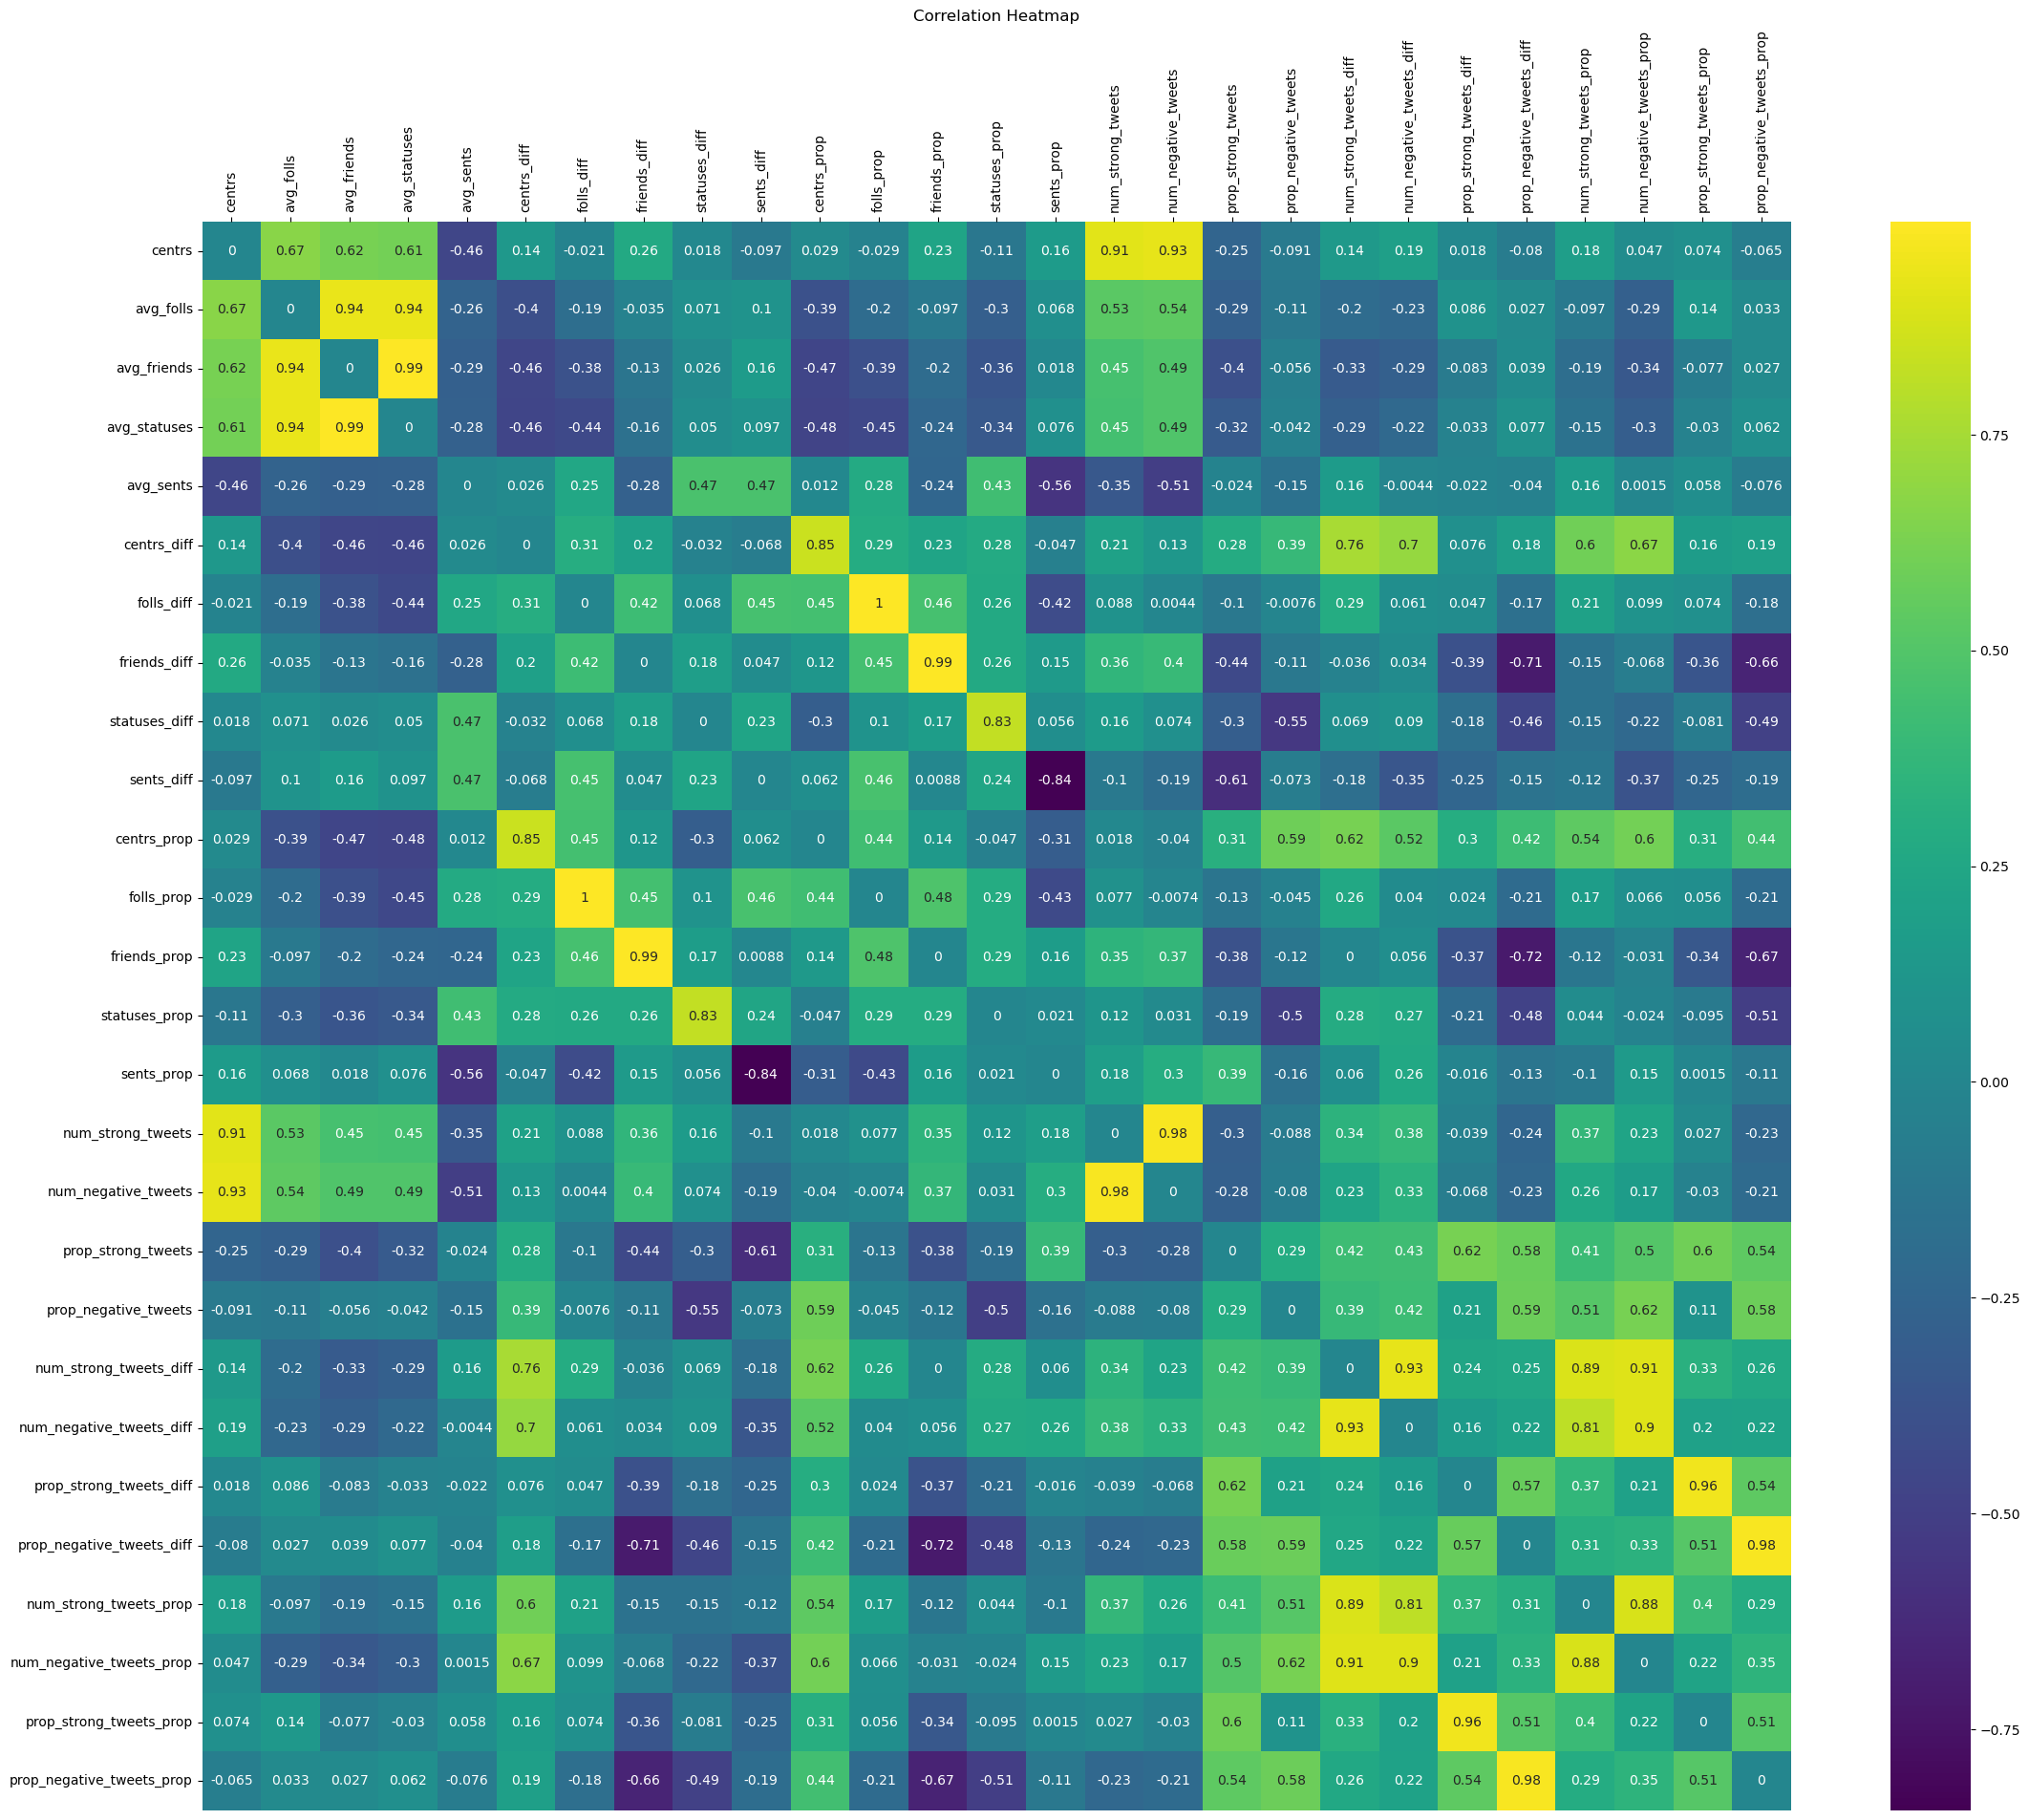

In [895]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, 
         centrs_prop, folls_prop, friends_prop, statuses_prop, sents_prop, 
         num_strong_tweets[1:], num_negative_tweets[1:], prop_strong_tweets[1:], prop_negative_tweets[1:],
         num_strong_tweets_diff, num_negative_tweets_diff, prop_strong_tweets_diff, prop_negative_tweets_diff,
         num_strong_tweets_prop, num_negative_tweets_prop, prop_strong_tweets_prop, prop_negative_tweets_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop',
          'num_strong_tweets', 'num_negative_tweets', 'prop_strong_tweets', 'prop_negative_tweets',
          'num_strong_tweets_diff', 'num_negative_tweets_diff', 'prop_strong_tweets_diff', 'prop_negative_tweets_diff',
          'num_strong_tweets_prop', 'num_negative_tweets_prop', 'prop_strong_tweets_prop', 'prop_negative_tweets_prop']

fig = plot2(lists, labels)

### Nit

In [889]:
user_id = 199120695
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)

In [890]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = np.array(num_strong_tweets), np.array(num_negative_tweets), np.array(prop_strong_tweets), np.array(prop_negative_tweets)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]
num_strong_tweets = num_strong_tweets[not_nan]
num_negative_tweets = num_negative_tweets[not_nan]
prop_strong_tweets = prop_strong_tweets[not_nan]
prop_negative_tweets = prop_negative_tweets[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)
num_strong_tweets_diff = np.diff(num_strong_tweets)
num_negative_tweets_diff = np.diff(num_negative_tweets)
prop_strong_tweets_diff = np.diff(prop_strong_tweets)
prop_negative_tweets_diff = np.diff(prop_negative_tweets)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])
num_strong_tweets_prop = num_strong_tweets[1:] / num_strong_tweets[:-1]
num_negative_tweets_prop = num_negative_tweets[1:] / num_negative_tweets[:-1]
prop_strong_tweets_prop = prop_strong_tweets[1:] / prop_strong_tweets[:-1]
prop_negative_tweets_prop = prop_negative_tweets[1:] / prop_negative_tweets[:-1]

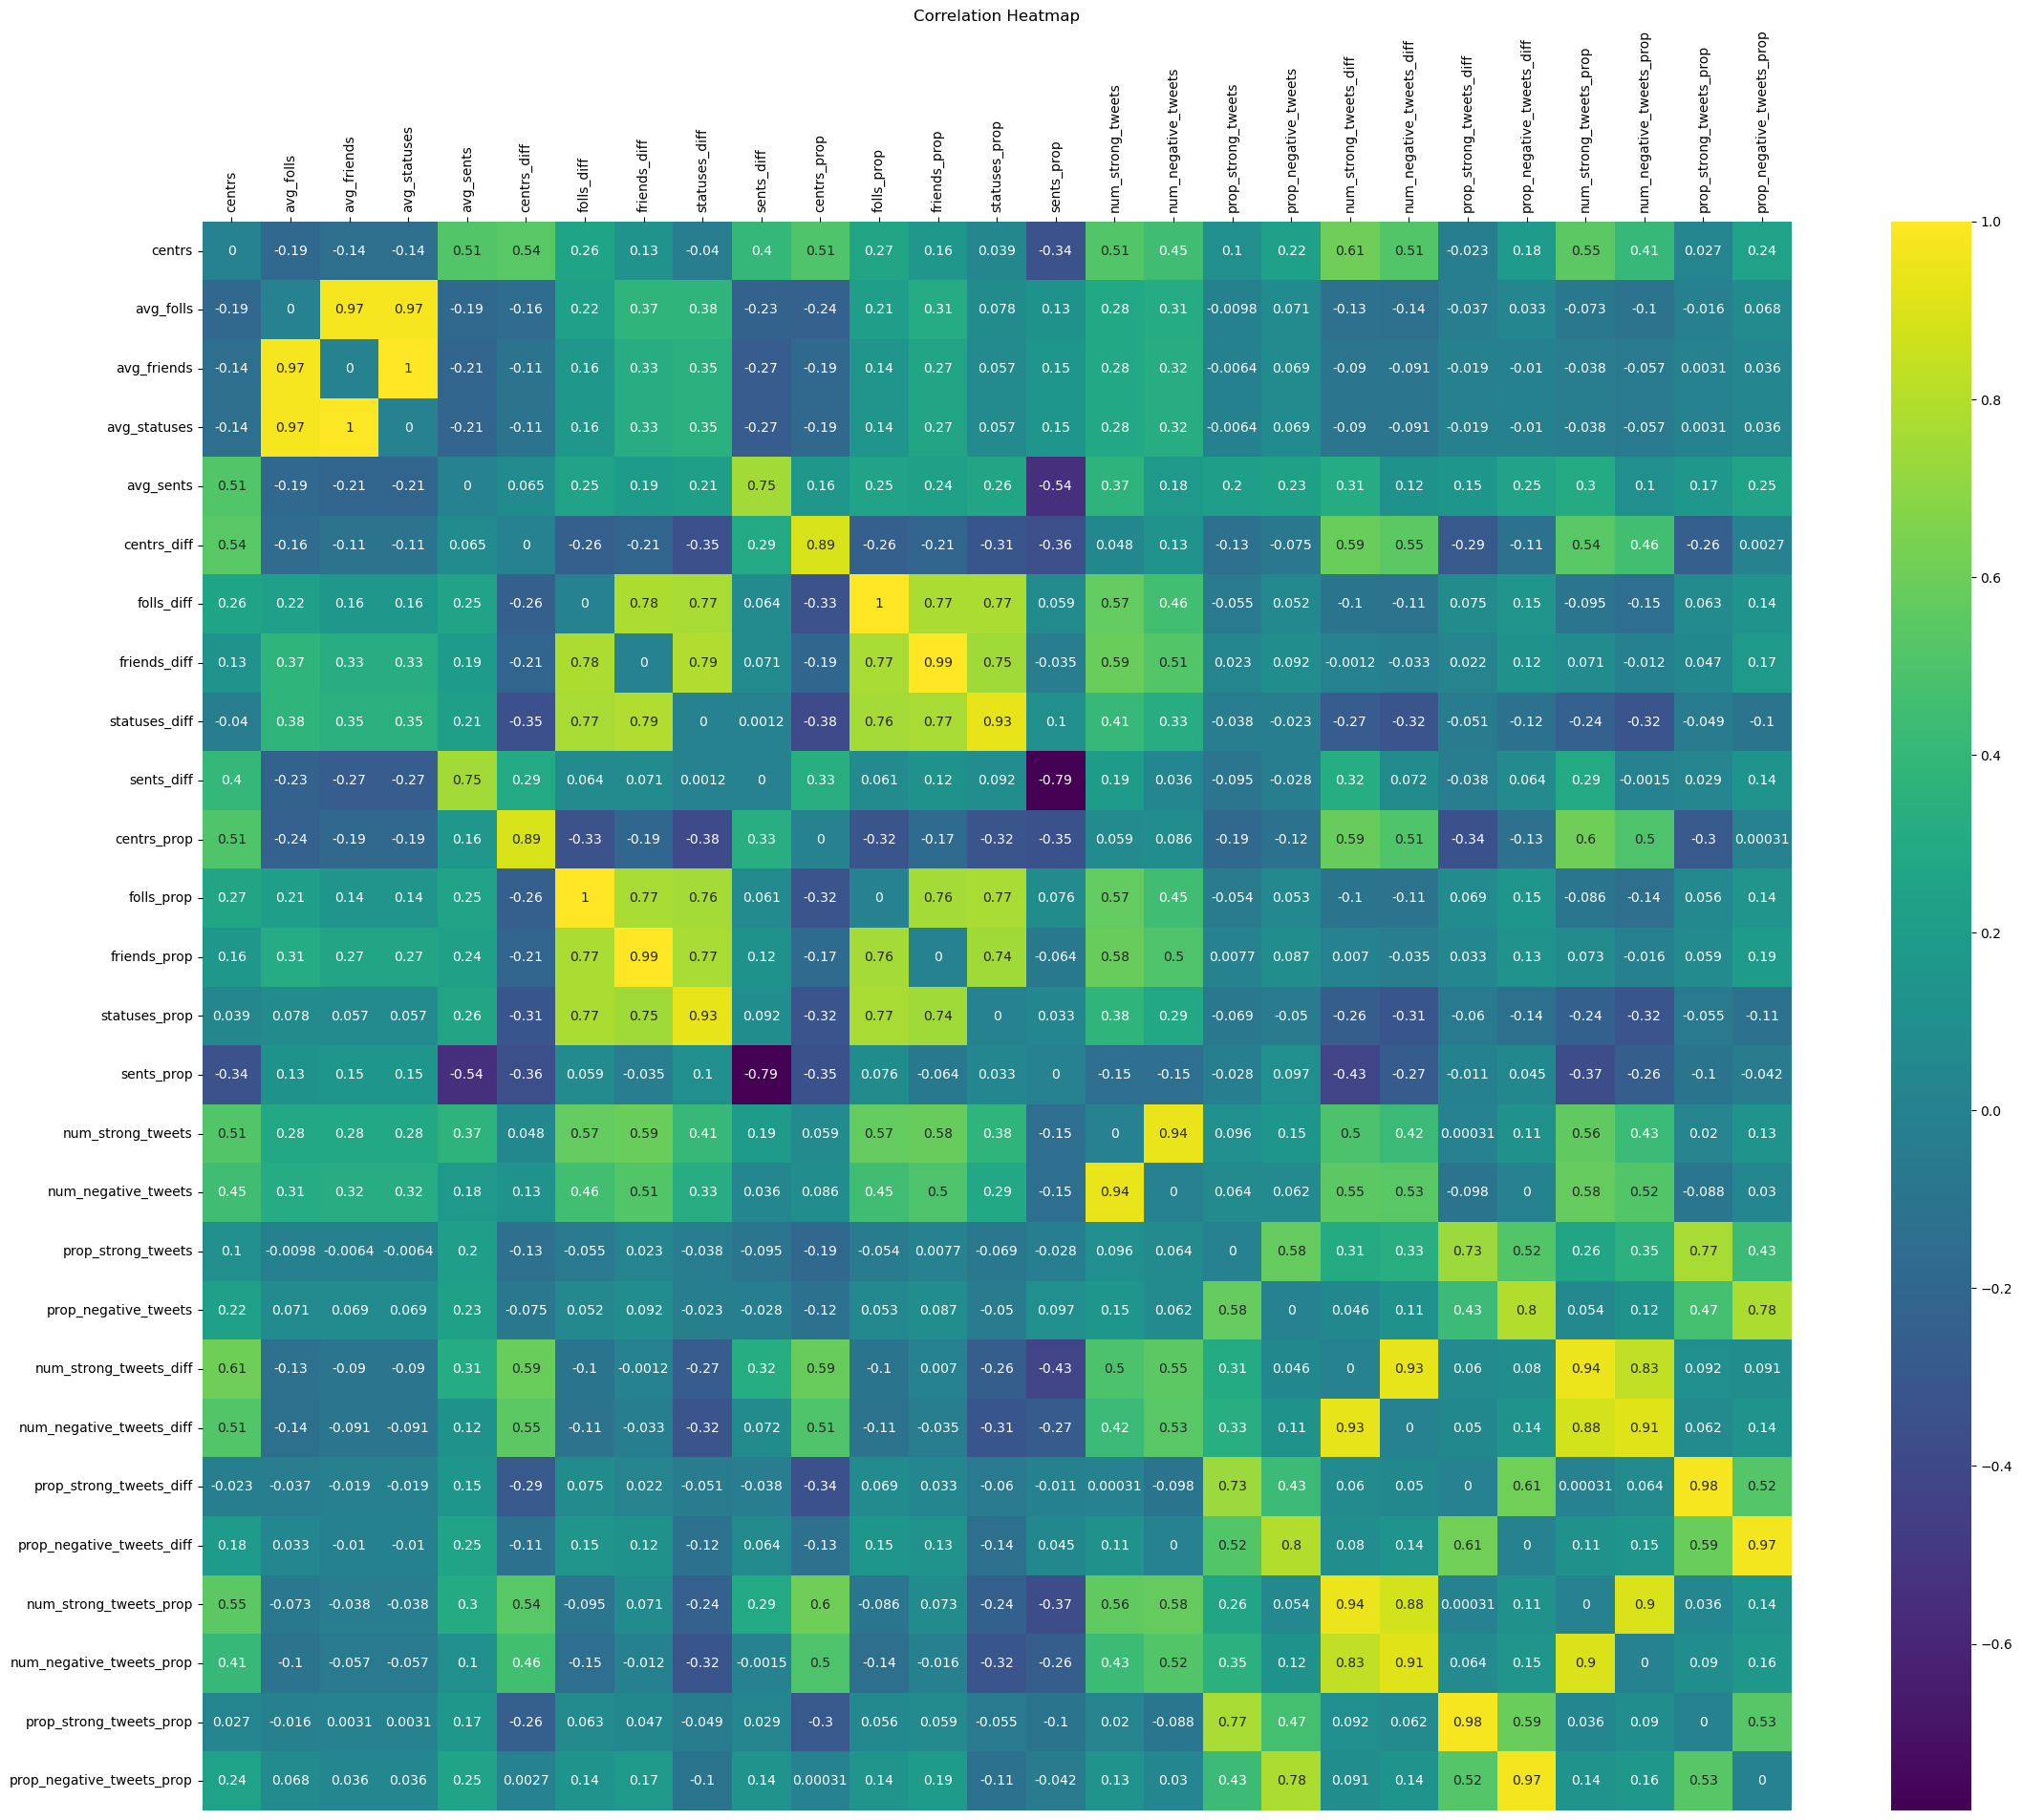

In [891]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, 
         centrs_prop, folls_prop, friends_prop, statuses_prop, sents_prop, 
         num_strong_tweets[1:], num_negative_tweets[1:], prop_strong_tweets[1:], prop_negative_tweets[1:],
         num_strong_tweets_diff, num_negative_tweets_diff, prop_strong_tweets_diff, prop_negative_tweets_diff,
         num_strong_tweets_prop, num_negative_tweets_prop, prop_strong_tweets_prop, prop_negative_tweets_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop',
          'num_strong_tweets', 'num_negative_tweets', 'prop_strong_tweets', 'prop_negative_tweets',
          'num_strong_tweets_diff', 'num_negative_tweets_diff', 'prop_strong_tweets_diff', 'prop_negative_tweets_diff',
          'num_strong_tweets_prop', 'num_negative_tweets_prop', 'prop_strong_tweets_prop', 'prop_negative_tweets_prop']

fig = plot2(lists, labels)

### Matt

In [912]:
user_id = 2185190036
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)

In [913]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = np.array(num_strong_tweets), np.array(num_negative_tweets), np.array(prop_strong_tweets), np.array(prop_negative_tweets)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]
num_strong_tweets = num_strong_tweets[not_nan]
num_negative_tweets = num_negative_tweets[not_nan]
prop_strong_tweets = prop_strong_tweets[not_nan]
prop_negative_tweets = prop_negative_tweets[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)
num_strong_tweets_diff = np.diff(num_strong_tweets)
num_negative_tweets_diff = np.diff(num_negative_tweets)
prop_strong_tweets_diff = np.diff(prop_strong_tweets)
prop_negative_tweets_diff = np.diff(prop_negative_tweets)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])
num_strong_tweets_prop = num_strong_tweets[1:] / num_strong_tweets[:-1]
num_negative_tweets_prop = num_negative_tweets[1:] / num_negative_tweets[:-1]
prop_strong_tweets_prop = prop_strong_tweets[1:] / prop_strong_tweets[:-1]
prop_negative_tweets_prop = prop_negative_tweets[1:] / prop_negative_tweets[:-1]

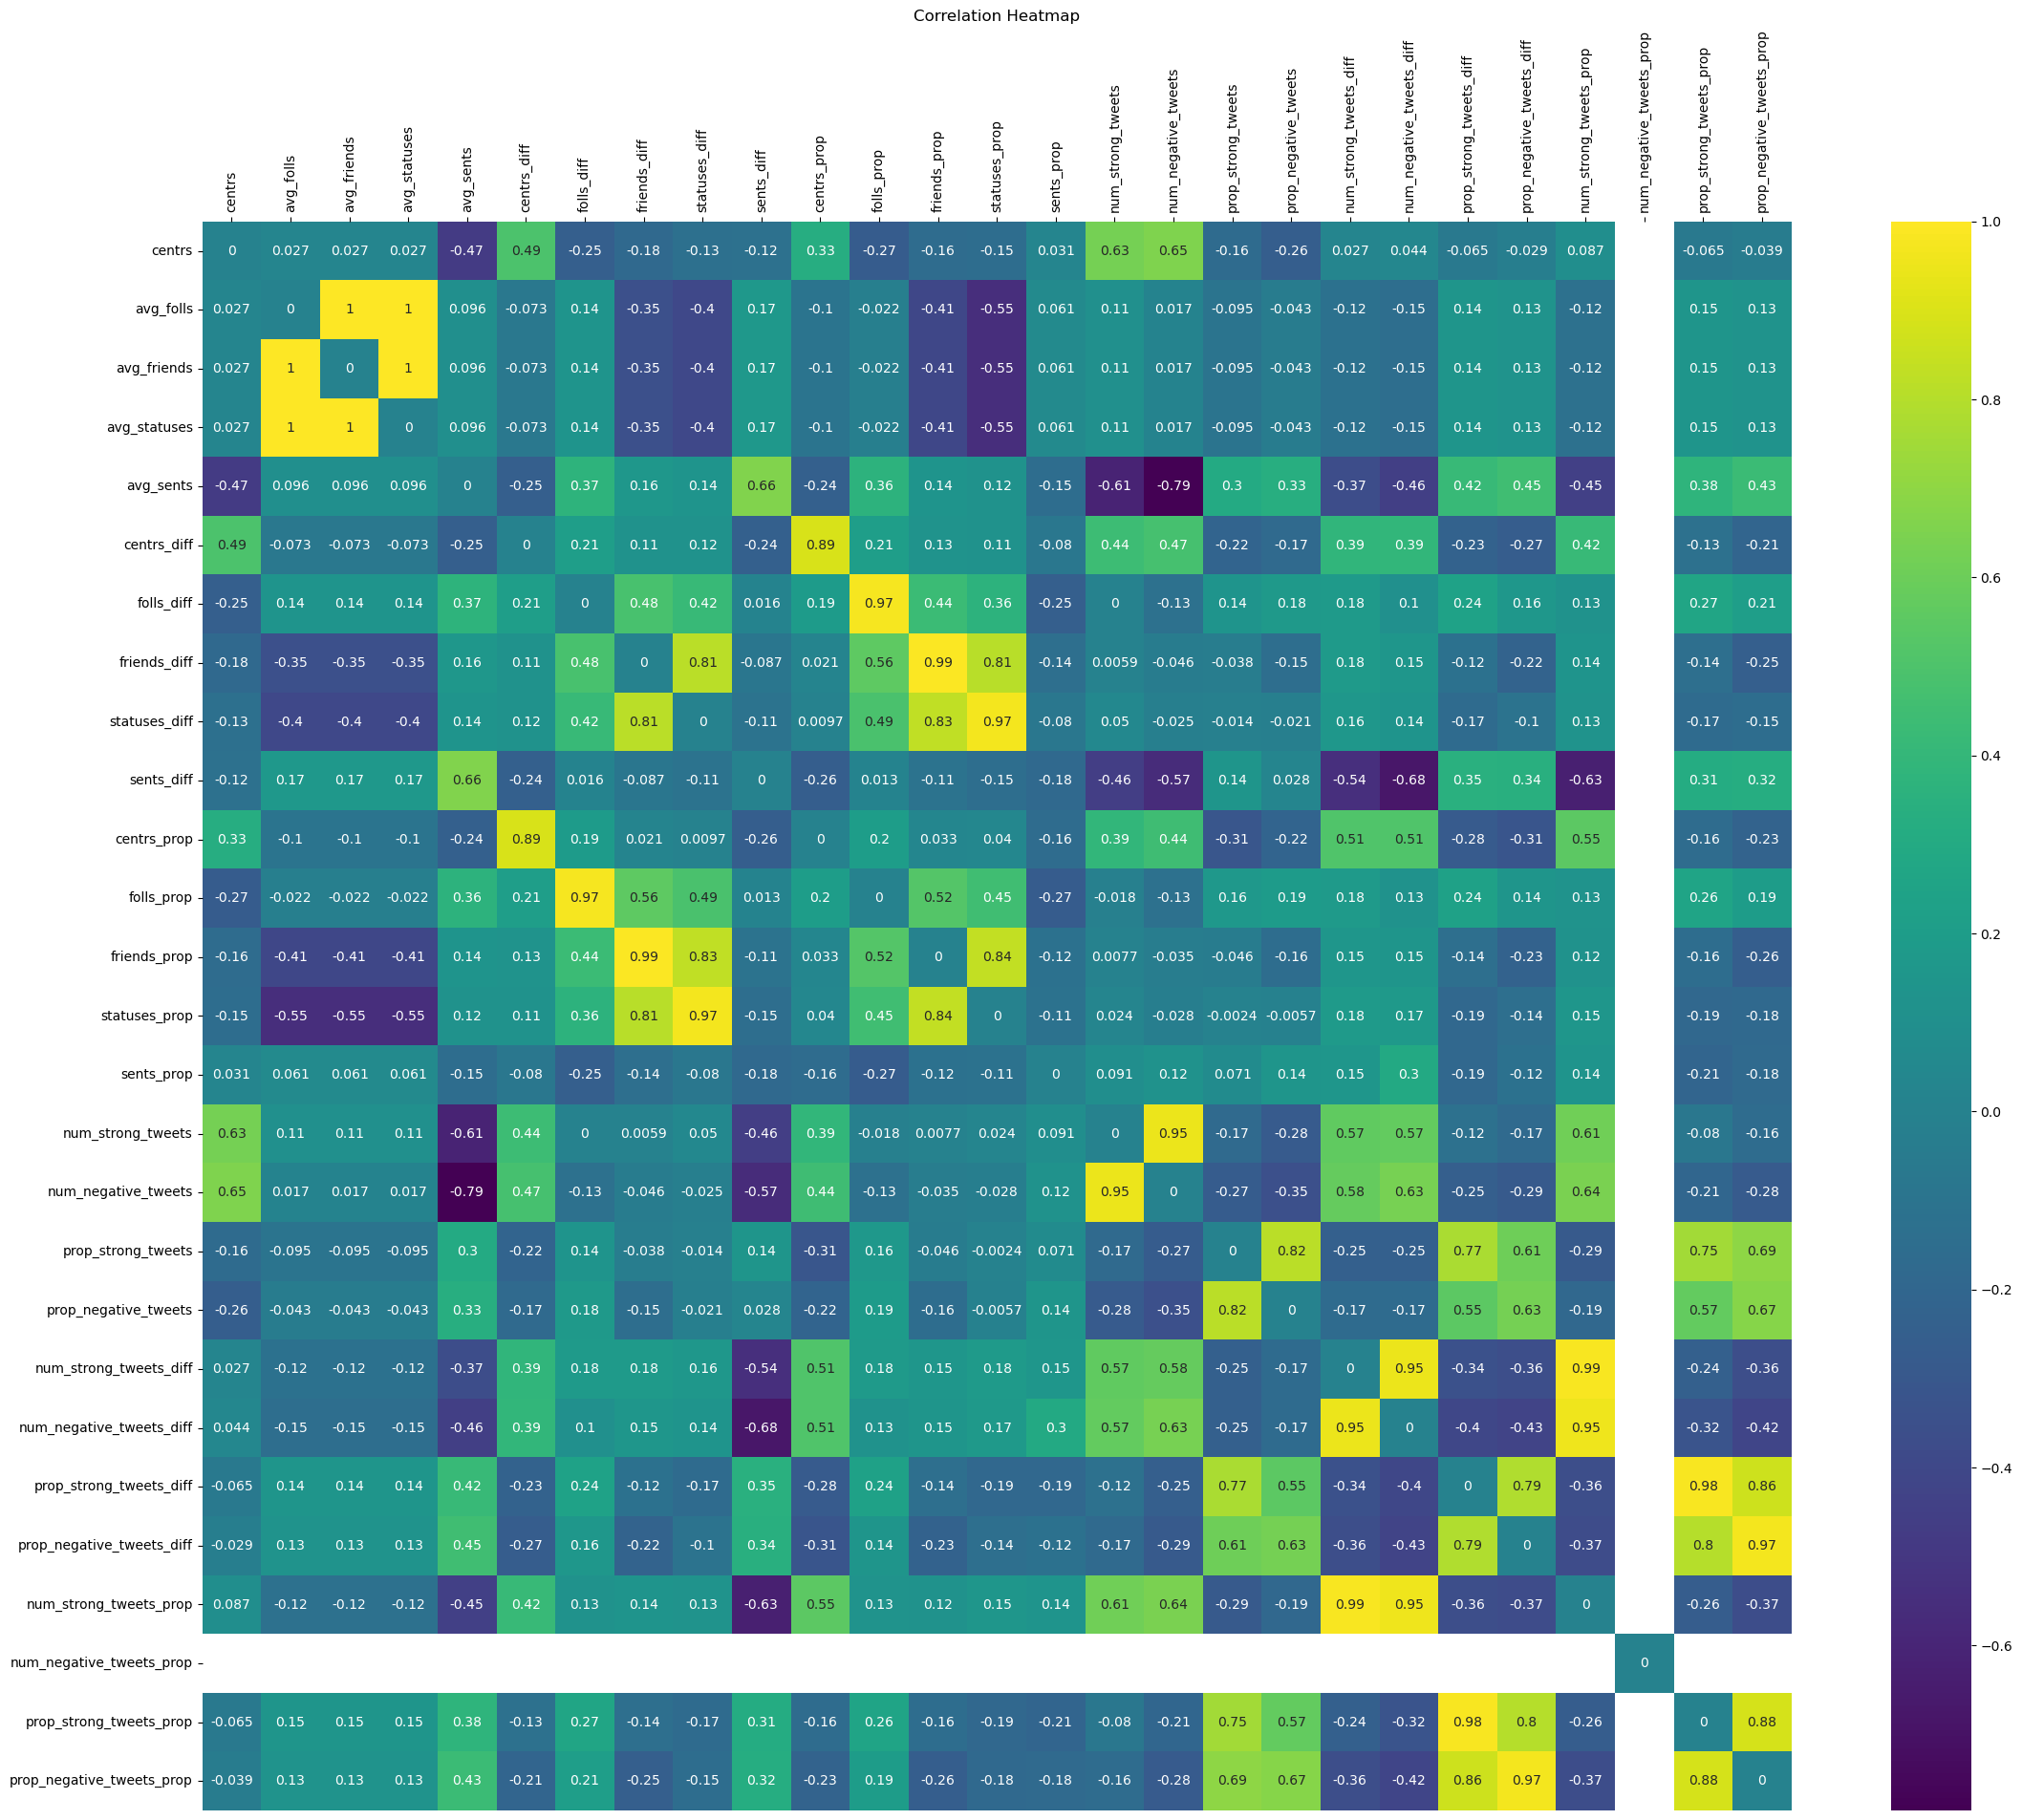

In [914]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, 
         centrs_prop, folls_prop, friends_prop, statuses_prop, sents_prop, 
         num_strong_tweets[1:], num_negative_tweets[1:], prop_strong_tweets[1:], prop_negative_tweets[1:],
         num_strong_tweets_diff, num_negative_tweets_diff, prop_strong_tweets_diff, prop_negative_tweets_diff,
         num_strong_tweets_prop, num_negative_tweets_prop, prop_strong_tweets_prop, prop_negative_tweets_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop',
          'num_strong_tweets', 'num_negative_tweets', 'prop_strong_tweets', 'prop_negative_tweets',
          'num_strong_tweets_diff', 'num_negative_tweets_diff', 'prop_strong_tweets_diff', 'prop_negative_tweets_diff',
          'num_strong_tweets_prop', 'num_negative_tweets_prop', 'prop_strong_tweets_prop', 'prop_negative_tweets_prop']

fig = plot2(lists, labels)

### Progress

In [916]:
user_id = 205240369
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)

In [917]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = np.array(num_strong_tweets), np.array(num_negative_tweets), np.array(prop_strong_tweets), np.array(prop_negative_tweets)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]
num_strong_tweets = num_strong_tweets[not_nan]
num_negative_tweets = num_negative_tweets[not_nan]
prop_strong_tweets = prop_strong_tweets[not_nan]
prop_negative_tweets = prop_negative_tweets[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)
num_strong_tweets_diff = np.diff(num_strong_tweets)
num_negative_tweets_diff = np.diff(num_negative_tweets)
prop_strong_tweets_diff = np.diff(prop_strong_tweets)
prop_negative_tweets_diff = np.diff(prop_negative_tweets)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])
num_strong_tweets_prop = num_strong_tweets[1:] / num_strong_tweets[:-1]
num_negative_tweets_prop = num_negative_tweets[1:] / num_negative_tweets[:-1]
prop_strong_tweets_prop = prop_strong_tweets[1:] / prop_strong_tweets[:-1]
prop_negative_tweets_prop = prop_negative_tweets[1:] / prop_negative_tweets[:-1]

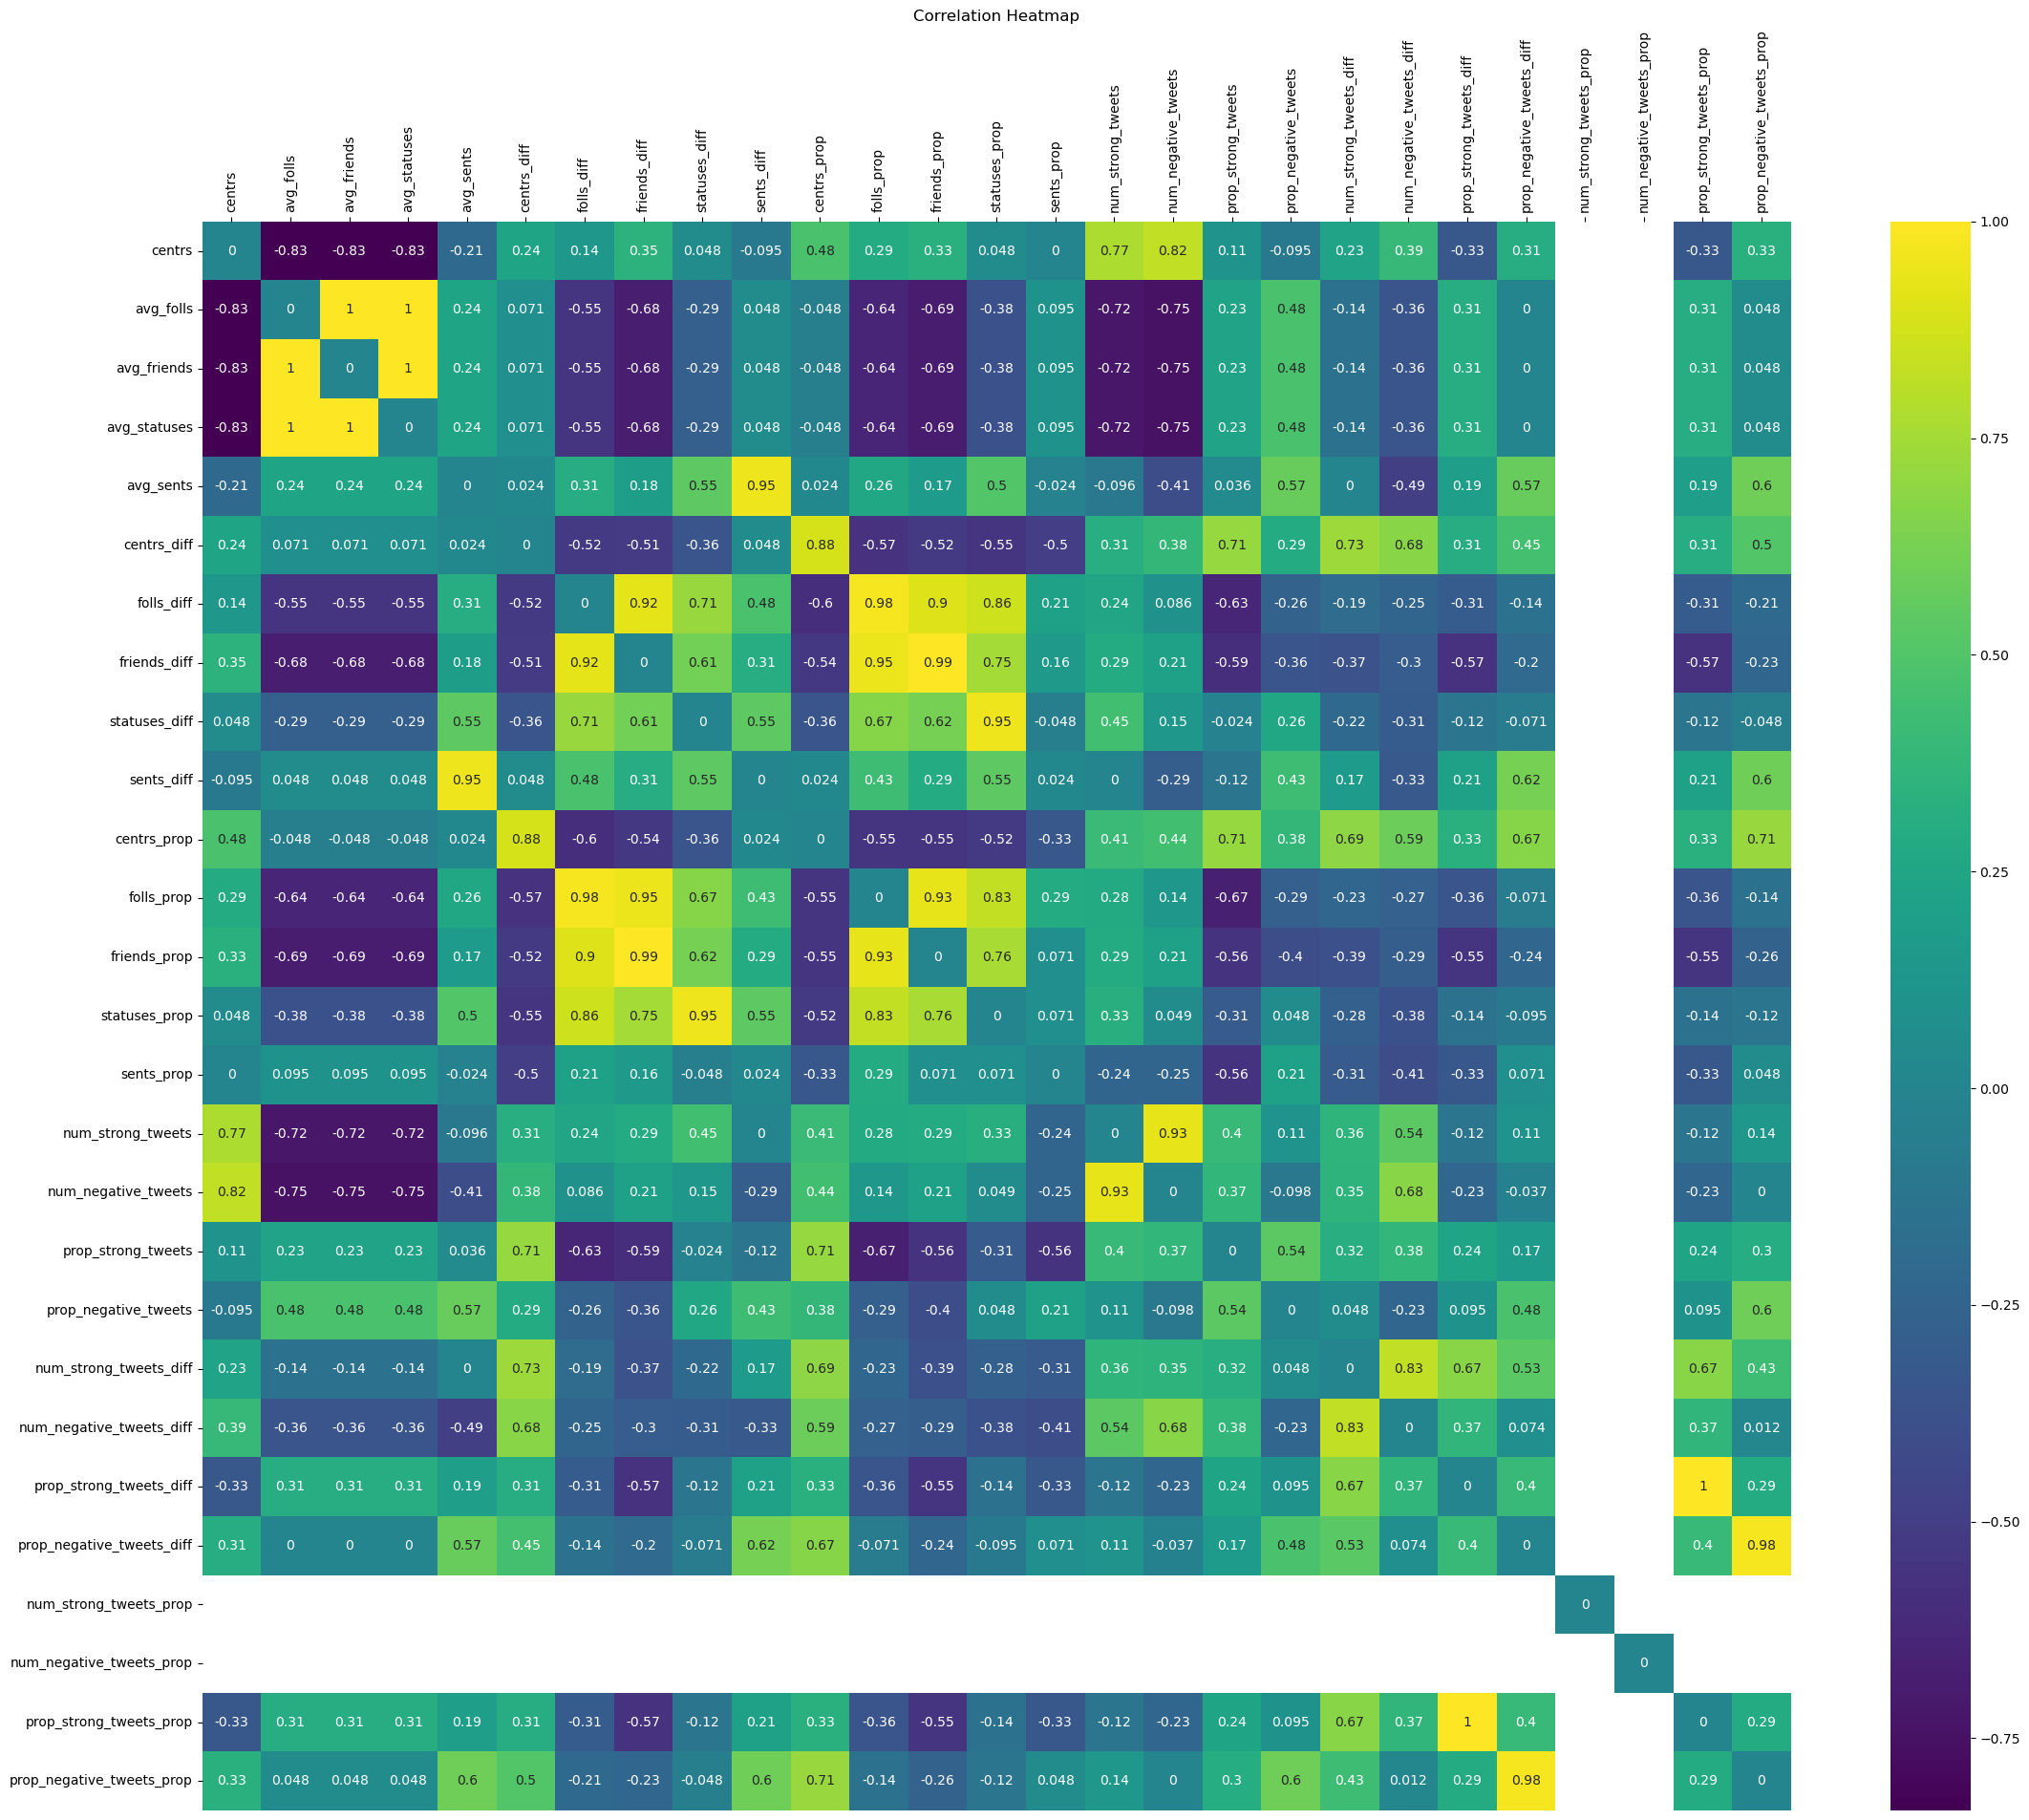

In [918]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, 
         centrs_prop, folls_prop, friends_prop, statuses_prop, sents_prop, 
         num_strong_tweets[1:], num_negative_tweets[1:], prop_strong_tweets[1:], prop_negative_tweets[1:],
         num_strong_tweets_diff, num_negative_tweets_diff, prop_strong_tweets_diff, prop_negative_tweets_diff,
         num_strong_tweets_prop, num_negative_tweets_prop, prop_strong_tweets_prop, prop_negative_tweets_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop',
          'num_strong_tweets', 'num_negative_tweets', 'prop_strong_tweets', 'prop_negative_tweets',
          'num_strong_tweets_diff', 'num_negative_tweets_diff', 'prop_strong_tweets_diff', 'prop_negative_tweets_diff',
          'num_strong_tweets_prop', 'num_negative_tweets_prop', 'prop_strong_tweets_prop', 'prop_negative_tweets_prop']

fig = plot2(lists, labels)

In [919]:
fig.savefig('./saves/progress correlation heatmap.png')

### Exploring Centrality vs Num Strong/Negative Tweets Correlation

In [938]:
userlist = list(top_5_users['user'][:4])
screenlist = list(top_5_users['screen name'][:4])

In [939]:
userlist, screenlist

([59047876, 199120695, 2185190036, 205240369],
 ['sophiatseliem', 'Nityalakshmi', 'mattlogical', 'Progress_orDie'])

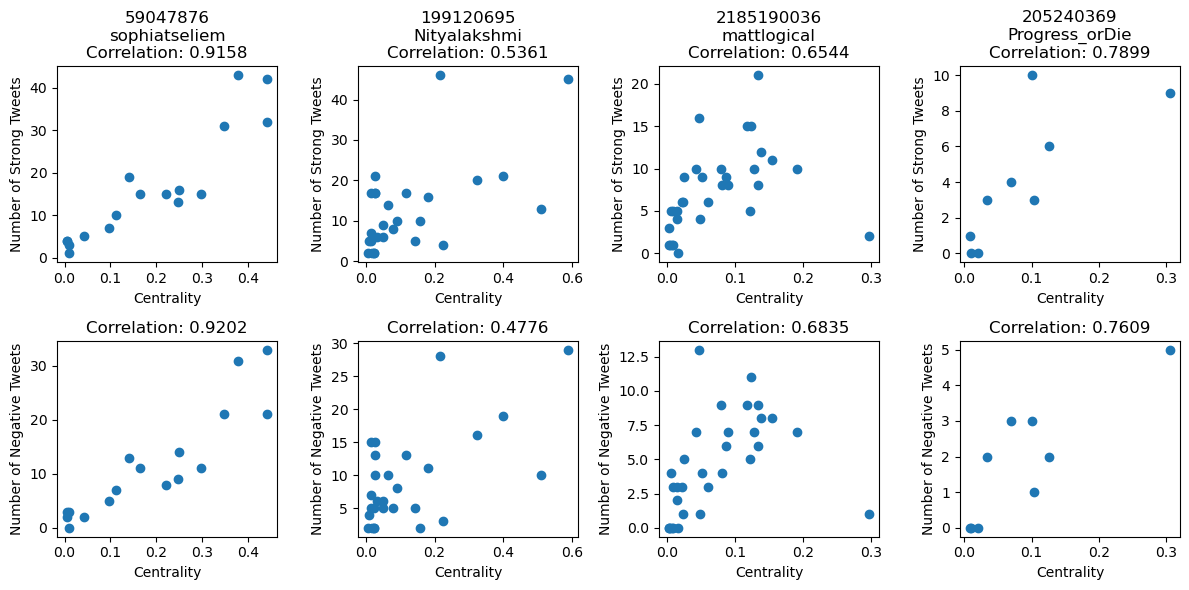

In [940]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))

for i in range(4):
    user_id = userlist[i]
    centrs = user_centrs[user_id]
    avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)
    
    centrs, num_strong_tweets, num_negative_tweets = np.array(centrs), np.array(num_strong_tweets), np.array(num_negative_tweets)
    not_nan = ~np.isnan(centrs)
    centrs = centrs[not_nan]
    num_strong_tweets = num_strong_tweets[not_nan]
    num_negative_tweets = num_negative_tweets[not_nan]
    
    scatter1 = ax[0, i].scatter(centrs, num_strong_tweets)
    scatter2 = ax[1, i].scatter(centrs, num_negative_tweets)
    
    correlation1, _ = stats.spearmanr(centrs, num_strong_tweets)
    correlation2, _ = stats.spearmanr(centrs, num_negative_tweets)
    
    ax[0, i].set_title(f"{userlist[i]}\n{screenlist[i]}\nCorrelation: {correlation1:.4f}")
    ax[1, i].set_title(f"Correlation: {correlation2:.4f}")
    
    ax[0, i].set_xlabel('Centrality')
    ax[0, i].set_ylabel('Number of Strong Tweets')
    
    ax[1, i].set_xlabel('Centrality')
    ax[1, i].set_ylabel('Number of Negative Tweets')
    
plt.tight_layout()
plt.show()

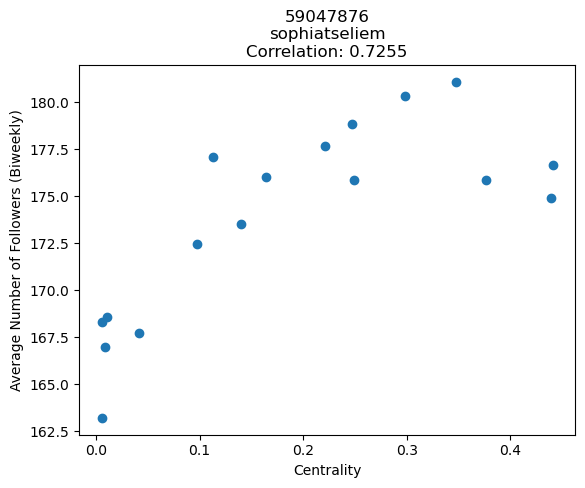

<Figure size 640x480 with 0 Axes>

In [948]:
i=0

user_id = userlist[i]
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)

centrs, num_strong_tweets, num_negative_tweets, avg_folls = np.array(centrs), np.array(num_strong_tweets), np.array(num_negative_tweets), np.array(avg_folls)
not_nan = ~np.isnan(centrs)
centrs = centrs[not_nan]
num_strong_tweets = num_strong_tweets[not_nan]
num_negative_tweets = num_negative_tweets[not_nan]
avg_folls = avg_folls[not_nan]

plt.scatter(centrs, avg_folls)

correlation, _ = stats.spearmanr(centrs, avg_folls)

plt.title(f"{userlist[i]}\n{screenlist[i]}\nCorrelation: {correlation:.4f}")

plt.xlabel('Centrality')
plt.ylabel('Average Number of Followers (Biweekly)')

plt.show()
plt.tight_layout()

### Plotting all users?

Should this be limited to not only 5 datapoints, but at least some number of strong or negative tweets?

In [951]:
df_c2 = pd.DataFrame(columns=df_c.columns)

path = './usersby2w-black/user_network_'

for index, row in tqdm(df_c.iterrows()):
    count = 0
    tweets = 0
    for date in biweekly_dates[:-1]:
        df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
        
        if row['user'] in list(df_date['user']):
            count += 1
            
    # if user appears in at least 5 biweek partitions
    if count >= 5:
        df_c2 = pd.concat([df_c2, pd.DataFrame([row])], ignore_index=True)

1195it [00:47, 24.93it/s]


In [952]:
len(df_c2)

928

In [556]:
df_c2

user  eigenvector centrality  weighted degree num tweets  \
0                 721373                0.031068       810.192299         37   
1                7221022                0.022672       609.255259         28   
2                8891042                0.023654       605.678618         23   
3               10041062                0.012739       351.525850         21   
4               10782182                0.032159       869.541705         33   
..                   ...                     ...              ...        ...   
587  1337092240813006848                0.017108       433.165563         29   
588  1337377197472894976                0.027323       719.562232         33   
589  1337401406827859968                0.064166      1615.906374         68   
590  1346992579523461120                0.005884       160.519059         12   
591  1354677924704653312                0.022866       573.672381         15   

    followers      screen name          prod  average sent num strong tweets  \
0         446         Swift818  3.613458e+05      0.055519                12   
1        1335     fonziewonzie  8.133558e+05      0.250657                16   
2        2341       Scandalous  1.417894e+06     -0.055696                 5   
3        5185      iamcindychu  1.822662e+06      0.091229                 9   
4       45662     mitchjackson  3.970501e+07      0.075136                 6   
..        ...              ...           ...           ...               ...   
587       213  cooliestillcool  9.226426e+04      0.150576                17   
588       162        DaricCott  1.165691e+05     -0.055606                 9   
589        47  Syssylittlefag1  7.594760e+04     -0.040172                22   
590        16     Bmo_The_Milf  2.568305e+03     -0.053717                 6   
591       156  MichaelKinnard6  8.949289e+04     -0.504493                10   

     prop strong tweets num negative tweets  prop negative tweets  
0              0.324324                   6              0.162162  
1              0.571429                   4              0.142857  
2              0.217391                   2              0.086957  
3              0.428571                   4              0.190476  
4              0.181818                   4              0.121212  
..                  ...                 ...                   ...  
587            0.586207                   7              0.241379  
588            0.272727                   6              0.181818  
589            0.323529                   2              0.029412  
590            0.500000                   3              0.250000  
591            0.666667                  10              0.666667  

[592 rows x 12 columns]

In [552]:
spearman_coeffs = {}
for user_id in tqdm(list(df_c2['user'])):
    avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)
    
    avg_folls, num_strong_tweets = np.array(avg_folls), np.array(num_strong_tweets)
    
    not_nan = ~np.isnan(avg_folls)

    avg_folls = avg_folls[not_nan]
    num_strong_tweets = num_strong_tweets[not_nan]
    
    folls_diff = np.diff(avg_folls)
    num_strong_tweets_diff = np.diff(num_strong_tweets)
    
    spearman_corr, p = stats.spearmanr(folls_diff, num_strong_tweets_diff)
    spearman_coeffs[user_id] = spearman_corr

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.27it/s]


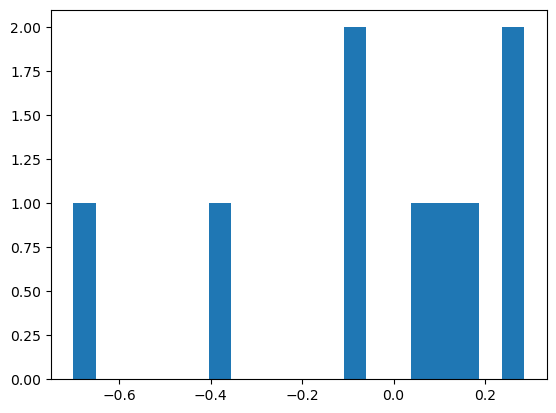

In [553]:
plt.hist(spearman_coeffs.values(), bins=20)
plt.show()

In [548]:
for k, v in spearman_coeffs.items():
    if np.abs(v) >= 0.9:
        print(k, v)

19670901 1.0
35439210 1.0
36660640 0.9486832980505139
59191086 -1.0
59522625 0.9486832980505139
81765090 -0.9486832980505139
116972959 0.9486832980505139
169648360 1.0
333674956 -0.9486832980505138
371386189 0.9258200997725515
439016986 -0.9486832980505138
470918844 -0.9746794344808963
551979401 0.9486832980505139
746579184 -0.9486832980505139
785229954 0.9486832980505139
1564437284 -1.0
1573107234 -1.0
2310813366 -0.9203131412633191
2384610859 -0.9486832980505139
3068632968 -0.9210526315789475
4922073732 -0.9486832980505139
803815211756945408 -0.9095085938862487
858161058569043968 0.9486832980505138


In [953]:
spearman_coeffs = {}
for user_id in tqdm(list(df_c2['user'])):
    avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)
    
    avg_folls, num_strong_tweets = np.array(avg_folls), np.array(num_strong_tweets)
    
    not_nan = ~np.isnan(avg_folls)

    avg_folls = avg_folls[not_nan]
    num_strong_tweets = num_strong_tweets[not_nan]
    
    spearman_corr, p = stats.spearmanr(avg_folls, num_strong_tweets)
    spearman_coeffs[user_id] = spearman_corr

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 928/928 [01:14<00:00, 12.41it/s]


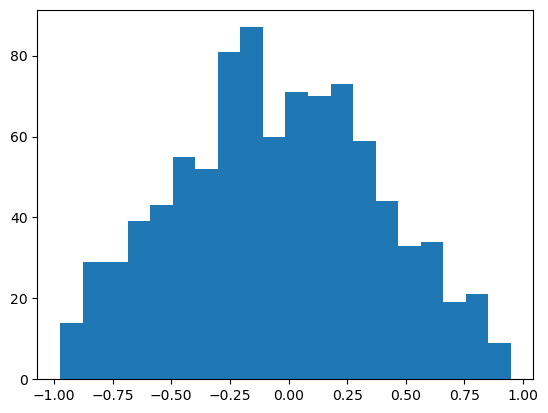

In [954]:
plt.hist(spearman_coeffs.values(), bins=20)
plt.show()

## Variance

In [949]:
df_c2 = pd.DataFrame(columns=df_c.columns)

path = './usersby2w-black/user_network_'

for index, row in tqdm(df_c.iterrows()):
    count = 0
    tweets = 0
    for date in biweekly_dates[:-1]:
        df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
        
        if row['user'] in list(df_date['user']):
            count += 1
            
    if count >= 5:
        df_c2 = pd.concat([df_c2, pd.DataFrame([row])], ignore_index=True)

562it [00:22, 25.10it/s]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [955]:
len(df_c2)

928

In [560]:
len(user_centrs)

1195

In [984]:
user_centrs_5 = {}
for k,v in tqdm(user_centrs.items()):
    if sum(~np.isnan(v)) >= 5:
        v = np.array(v)
        v = v[~np.isnan(v)]
        user_centrs_5[k] = v

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1195/1195 [00:00<00:00, 48951.02it/s]


In [985]:
user_degrees_5 = {}
for k,v in tqdm(user_degrees.items()):
    if sum(~np.isnan(v)) >= 5:
        v = np.array(v)
        v = v[~np.isnan(v)]
        user_degrees_5[k] = v

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1195/1195 [00:00<00:00, 57571.05it/s]


In [986]:
len(user_centrs_5), len(user_degrees_5)

(928, 928)

In [988]:
centrs_mean = [np.mean(v) for v in user_centrs_5.values()]
centrs_variance = [np.var(v) for v in user_centrs_5.values()]
degrees_mean = [np.mean(v) for v in user_degrees_5.values()]
degrees_variance = [np.var(v) for v in user_degrees_5.values()]

Centrality histograms. Notice that plotting overall centrality distribution looks similar to plotting their means over at least 5 biweeks, but the values are far larger overall due to variance.

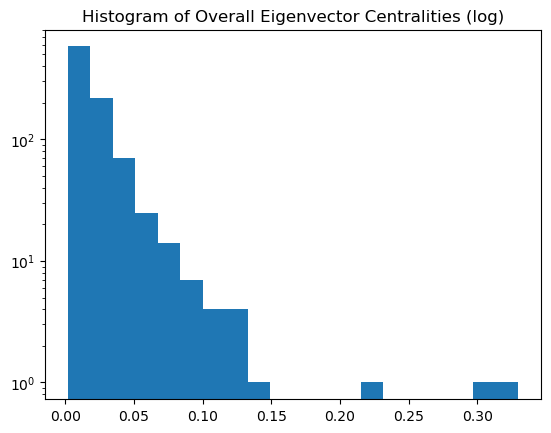

In [1004]:
plt.hist(df_c2['eigenvector centrality'], bins=20)
plt.yscale('log')
plt.title('Histogram of Overall Eigenvector Centralities (log)')
plt.show()

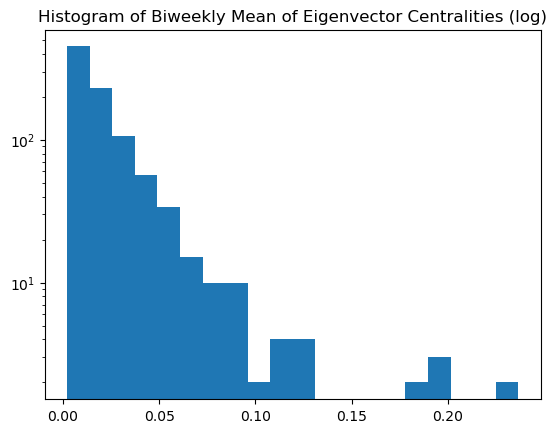

In [1005]:
plt.hist(centrs_mean, bins=20)
plt.yscale('log')
plt.title('Histogram of Biweekly Mean of Eigenvector Centralities (log)')
plt.show()

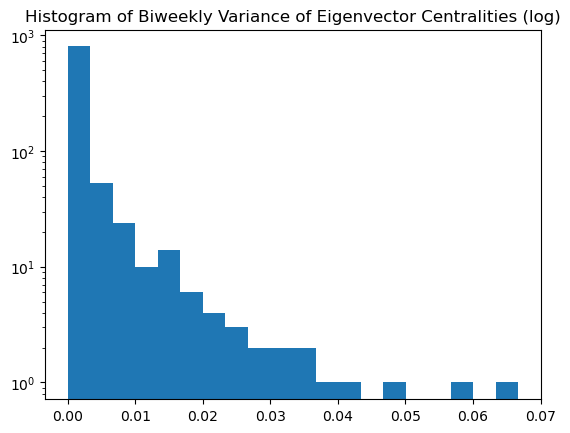

In [1006]:
plt.hist(centrs_variance, bins=20)
plt.yscale('log')
plt.title('Histogram of Biweekly Variance of Eigenvector Centralities (log)')
plt.show()

Weighted degree histograms.

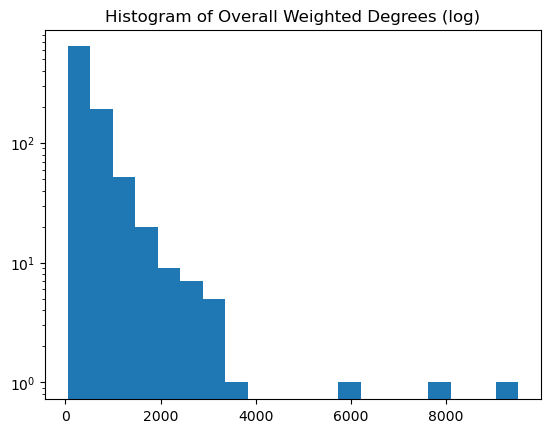

In [1007]:
plt.hist(df_c2['weighted degree'], bins=20)
plt.yscale('log')
plt.title('Histogram of Overall Weighted Degrees (log)')
plt.show()

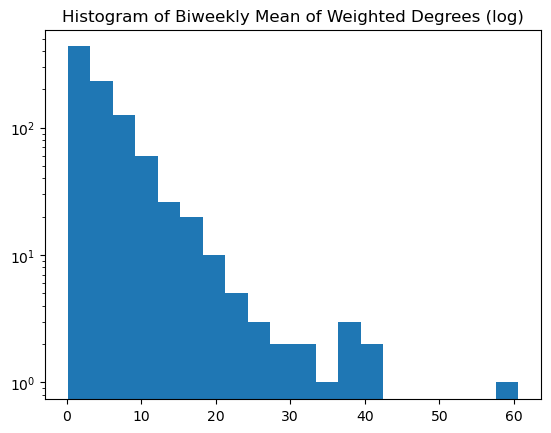

In [1008]:
plt.hist(degrees_mean, bins=20)
plt.yscale('log')
plt.title('Histogram of Biweekly Mean of Weighted Degrees (log)')
plt.show()

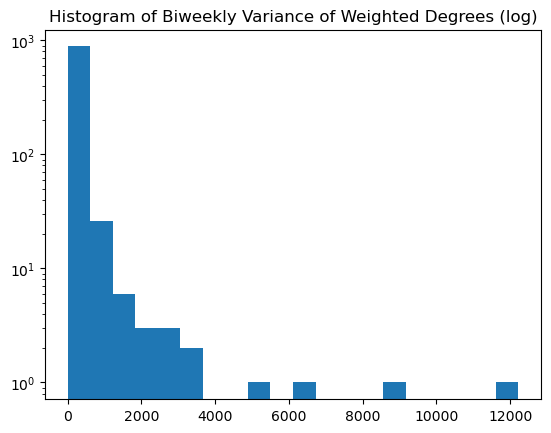

In [1009]:
plt.hist(degrees_variance, bins=20)
plt.yscale('log')
plt.title('Histogram of Biweekly Variance of Weighted Degrees (log)')
plt.show()

## Weight Histogram

In [245]:
with open(f'./user networks/relations_black.pkl', 'rb') as f:
    relations = pickle.load(f)

In [1037]:
x = [z[2] for z in relations]

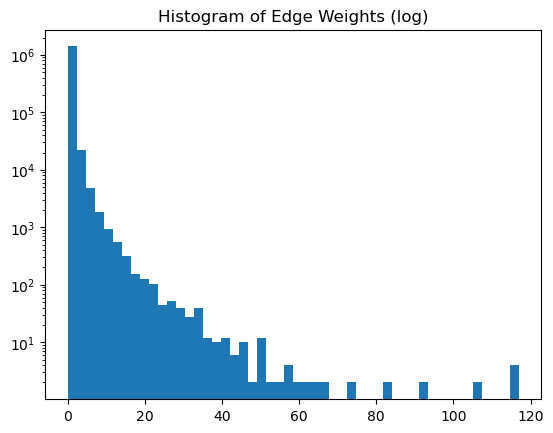

In [1039]:
plt.hist(x, bins=50)
plt.yscale('log')
plt.title('Histogram of Edge Weights (log)')
plt.show()

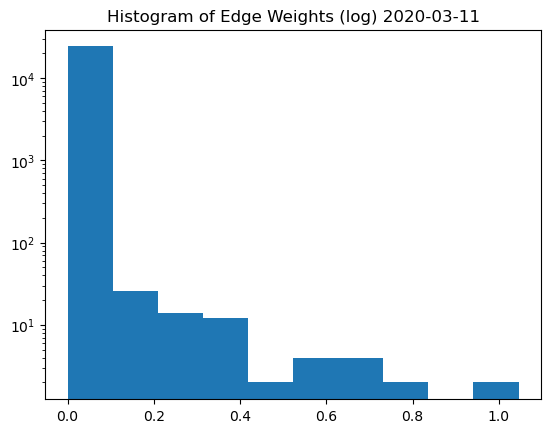

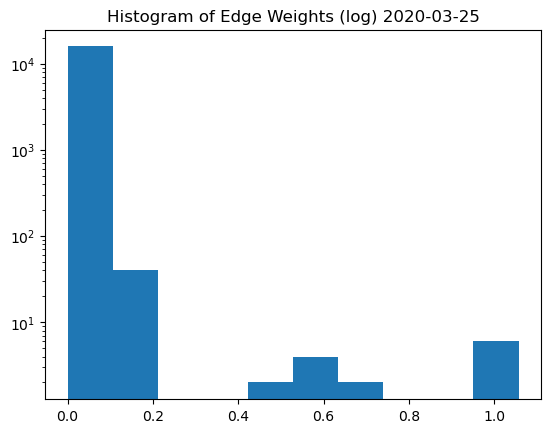

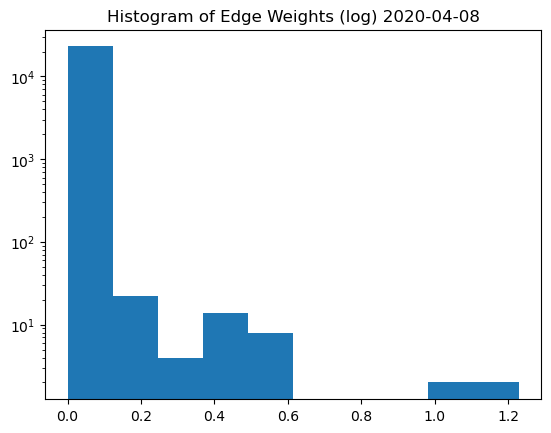

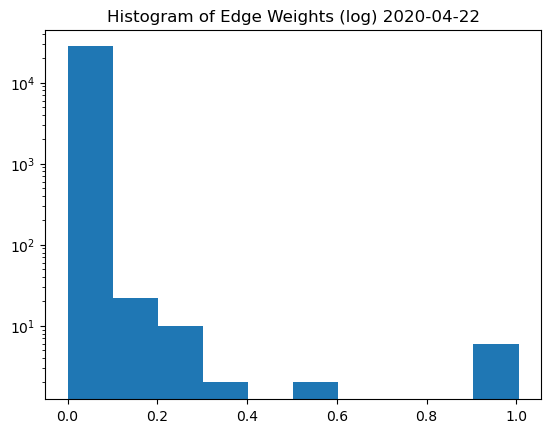

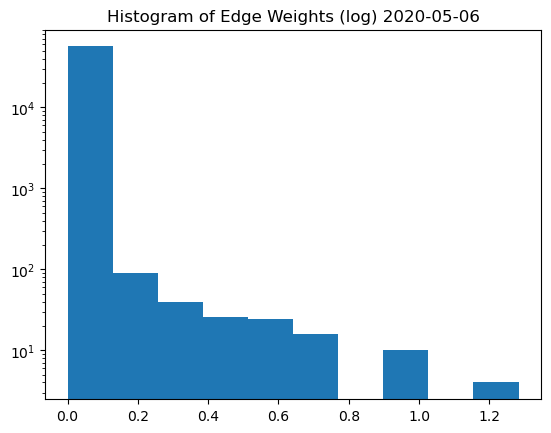

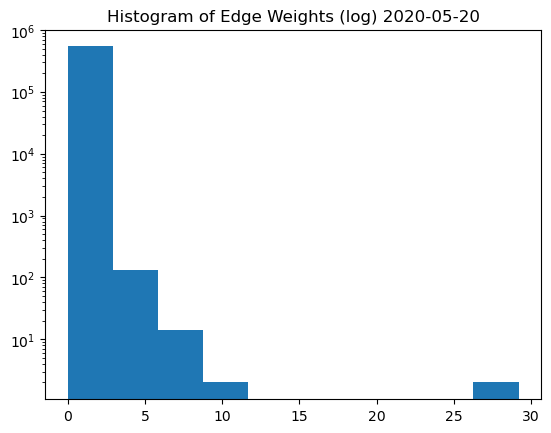

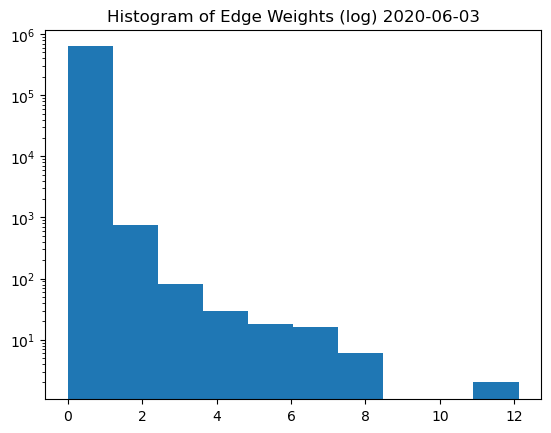

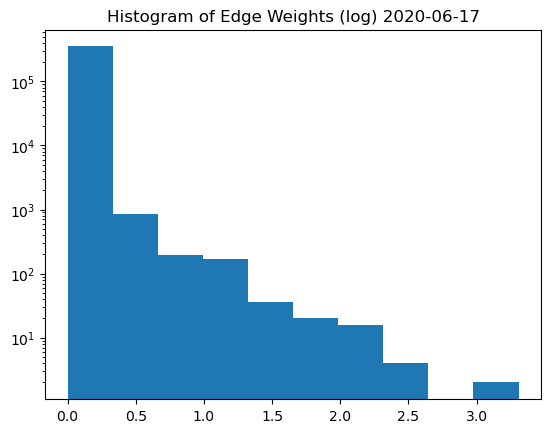

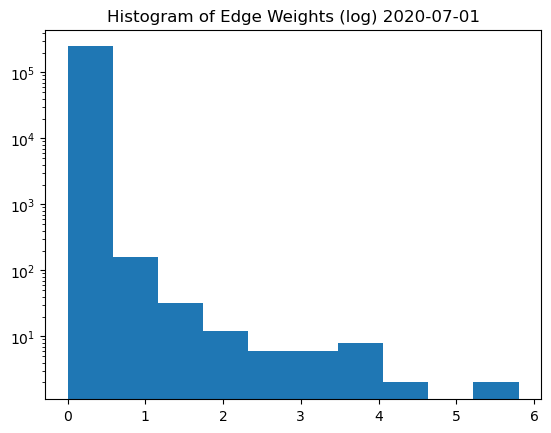

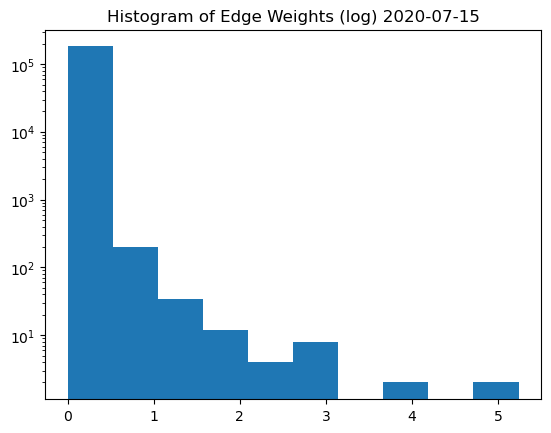

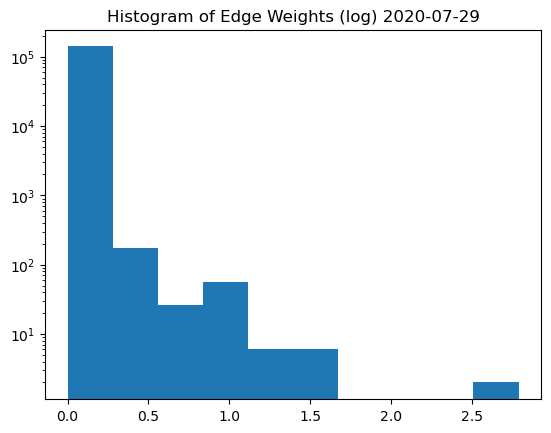

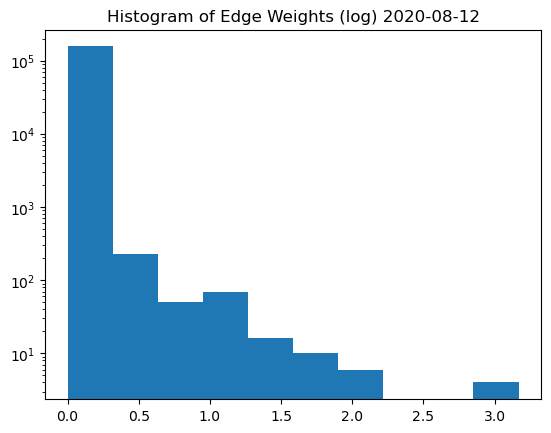

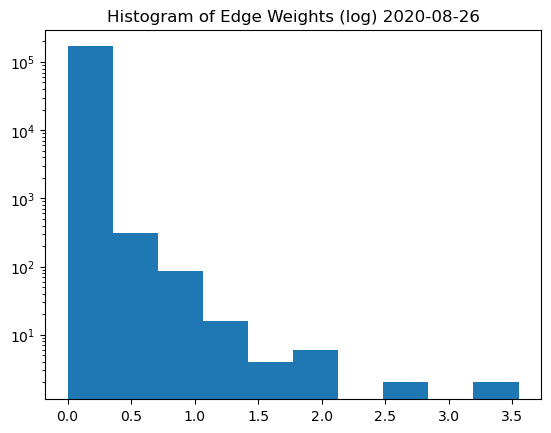

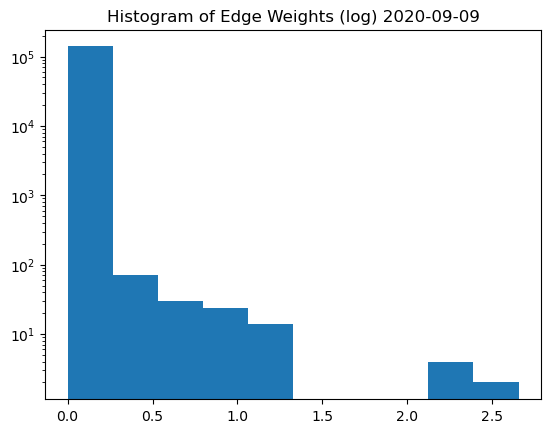

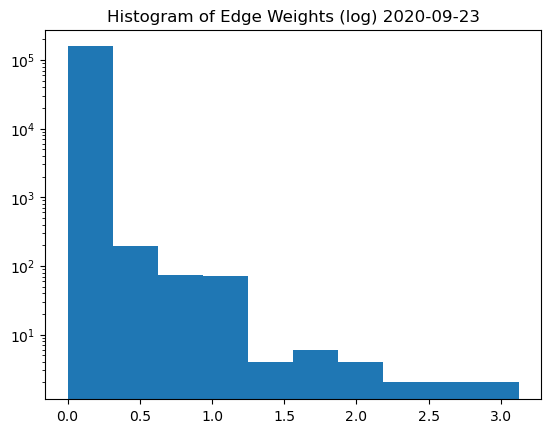

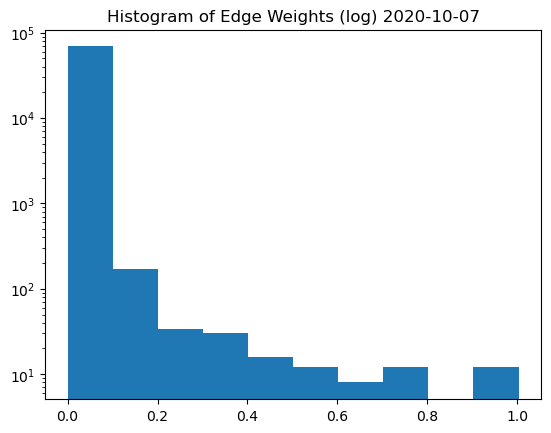

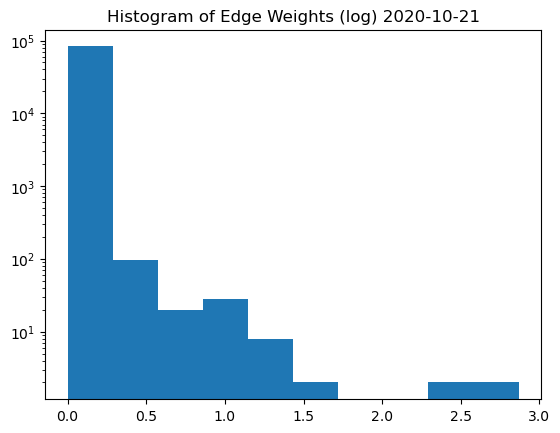

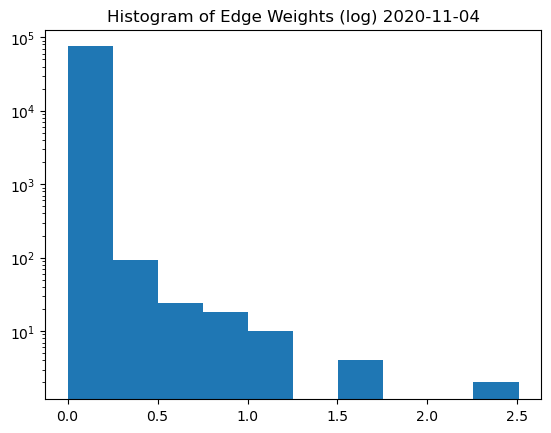

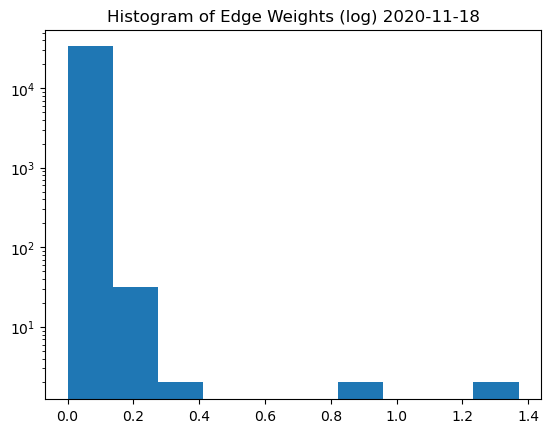

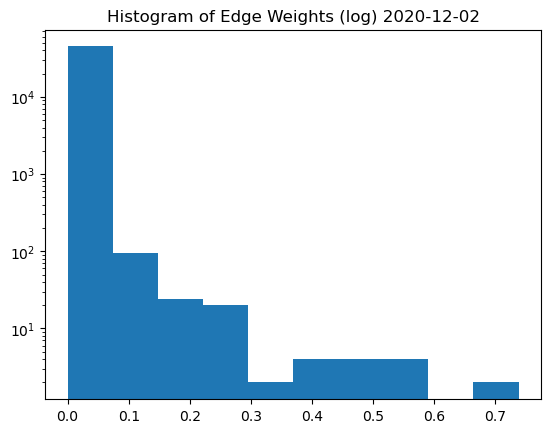

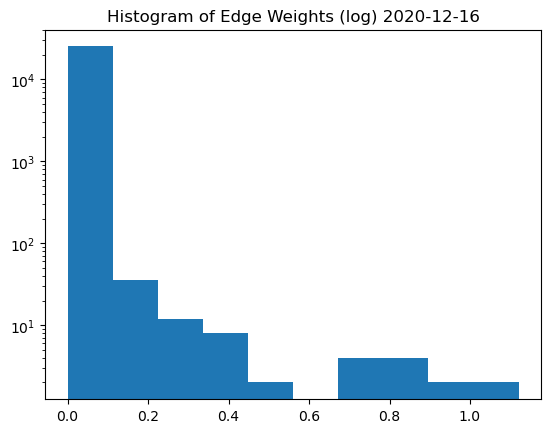

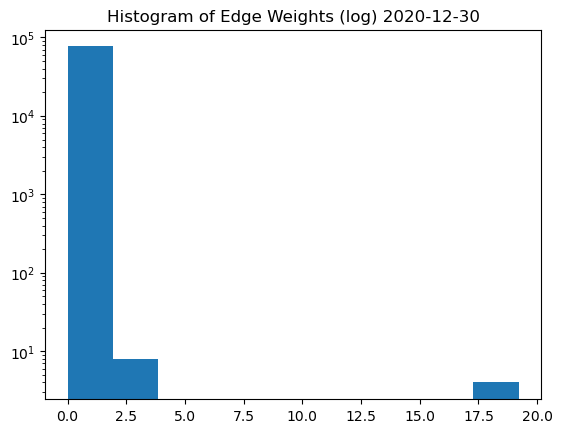

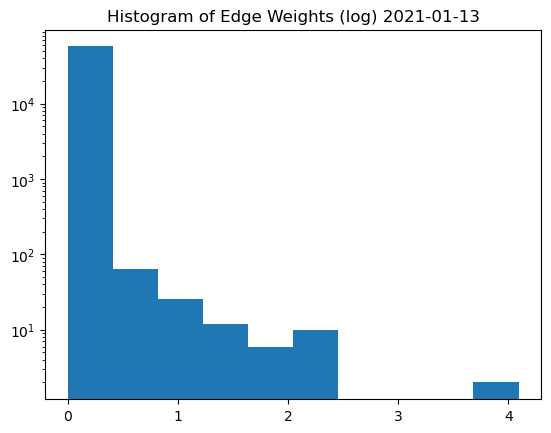

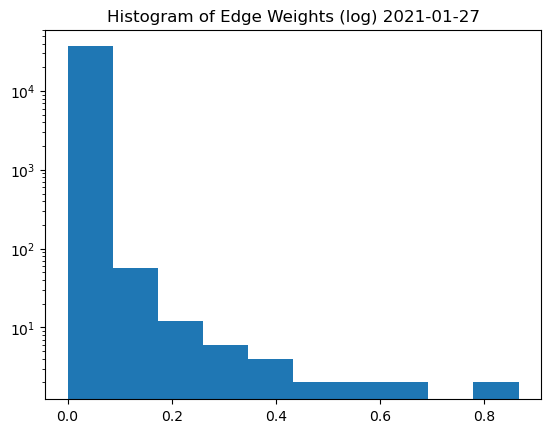

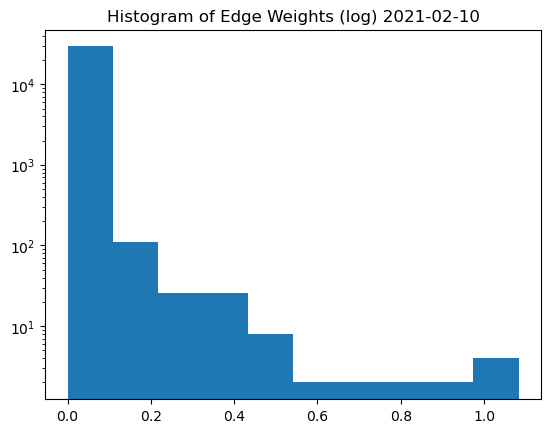

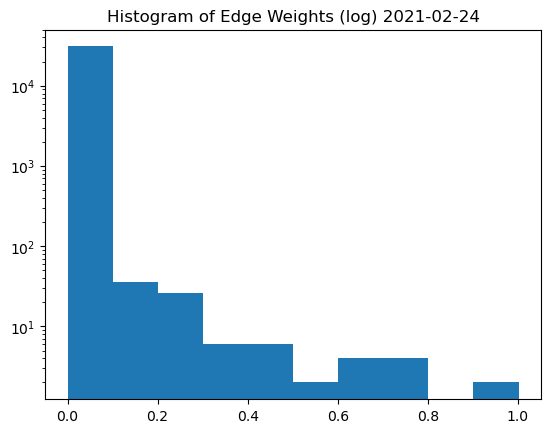

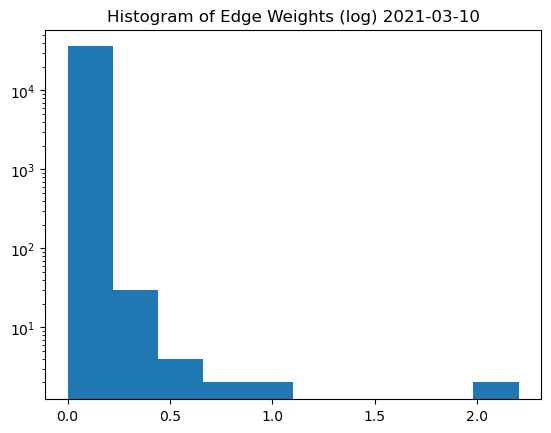

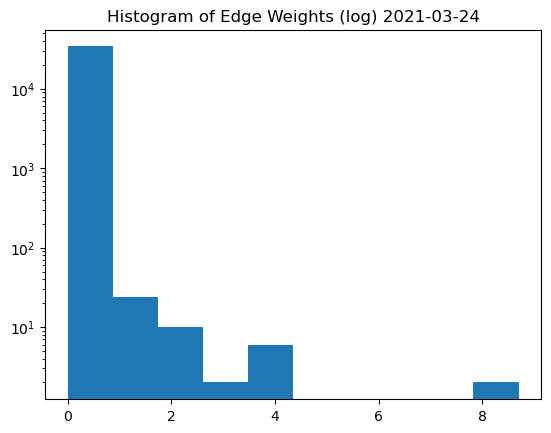

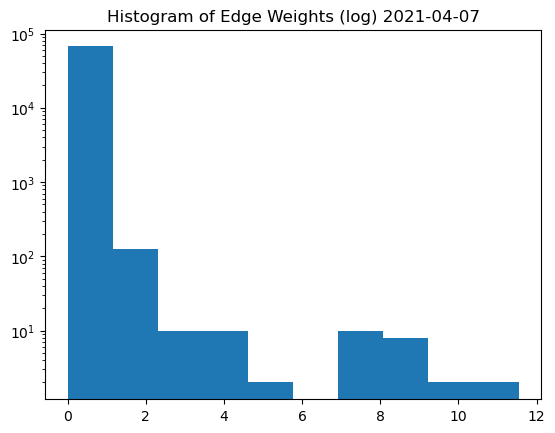

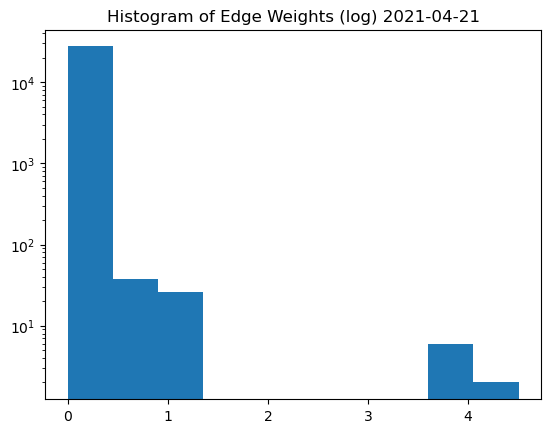

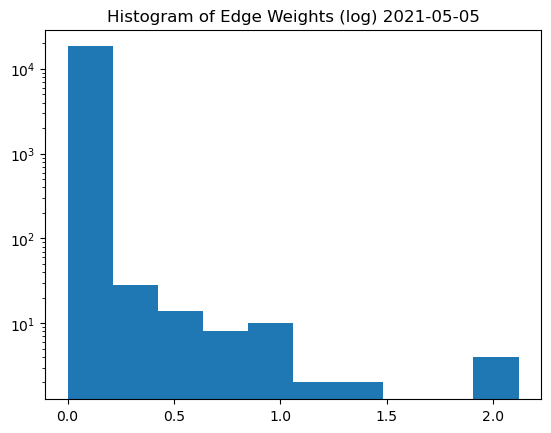

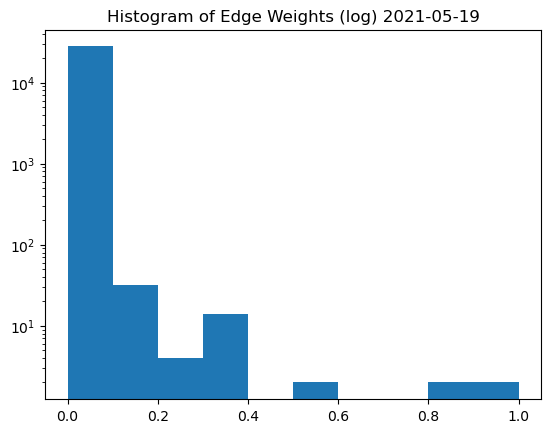

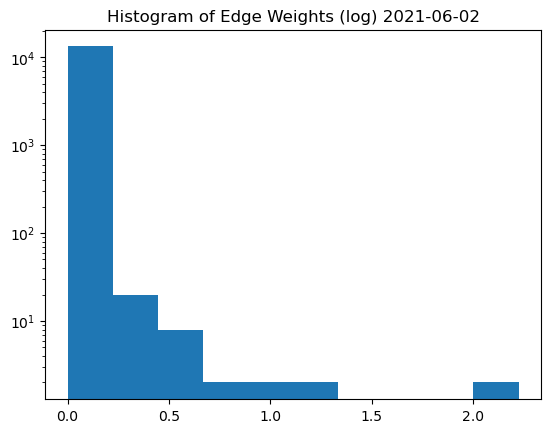

In [ ]:
for date in biweekly_dates[:-1]:
    with open(f'./usersby2w-black/relations_{str(date)[:10]}.pkl', 'rb') as f:
        relations = pickle.load(f)
        
    x = [z[2] for z in relations]
    plt.hist(x)
    plt.yscale('log')
    plt.title(f'Histogram of Edge Weights (log) {str(date)[:10]}')
    plt.show()

## Plotting Centrality change over Time for Top 5 MOST INFLUENTIAL users, biweekly, among users who tweeted 10+ times

In [9]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

In [62]:
path = './usersby2w-black/user_network_'

user_centrs = {}
user_degrees = {}
user_sents = {}

for user in tqdm(list(df_c['user'])):
    centrs = []
    degrees = []
    sents = []
    for date in biweekly_dates[:-1]:
        df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
        try:
            centrs.append(df_date[df_date['user'] == user]['eigenvector centrality'].iloc[0])
            degrees.append(df_date[df_date['user'] == user]['weighted degree'].iloc[0])
            sents.append(df_date[df_date['user'] == user]['average sent'].iloc[0])
        except:
            centrs.append(np.nan)
            degrees.append(np.nan)
            sents.append(np.nan)
    user_centrs[user] = centrs 
    user_degrees[user] = degrees
    user_sents[user] = sents

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1195/1195 [00:58<00:00, 20.55it/s]


In [11]:
df_c.columns

Index(['user', 'eigenvector centrality', 'weighted degree', 'num tweets',
       'followers', 'screen name', 'prod', 'average sent', 'num strong tweets',
       'prop strong tweets', 'num negative tweets', 'prop negative tweets'],
      dtype='object')

In [50]:
df_c['prod2'] = df_c['weighted degree'] * np.log1p(df_c['followers'])

In [51]:
top_5_users = df_c.sort_values(by='prod2', ascending=False).iloc[:10]

In [87]:
top_5_users

user  eigenvector centrality  weighted degree  num tweets  \
448           199120695                0.297871      8053.441088         417   
285            59047876                0.329947      9518.461504         405   
733          2185190036                0.223639      5967.849716         371   
735          2234760798                0.114745      3185.769852         104   
214            37039868                0.111720      2966.719364         142   
574           473384312                0.128157      3208.616266         120   
952  899404385700073472                0.095212      2530.337400         125   
823          3133488306                0.078231      2189.337314         111   
453           205240369                0.144378      3537.263125         102   
750          2323052250                0.101641      2612.390572         116   

     followers      screen name          prod  average sent  \
448        885     Nityalakshmi  7.127295e+06     -0.223182   
285        163    sophiatseliem  1.551509e+06     -0.191473   
733       1254      mattlogical  7.483684e+06     -0.079958   
735      17869      MikeSington  5.692652e+07     -0.234722   
214      10411   MichaelPGrande  3.088652e+07     -0.017851   
574        683  dandlionalchemy  2.191485e+06      0.010796   
952       3439  IAmKrishanPatel  8.701830e+06     -0.140676   
823       9309      TassajaraRd  2.038054e+07      0.246568   
453        282   Progress_orDie  9.975082e+05      0.026492   
750       1789       Mudaship39  4.673567e+06     -0.204694   

     num strong tweets  prop strong tweets  num negative tweets  \
448                235            0.563549                  178   
285                142            0.350617                  123   
733                105            0.283019                   74   
735                 46            0.442308                   37   
214                 46            0.323944                   27   
574                 26            0.216667                   11   
952                 43            0.344000                   35   
823                 37            0.333333                    9   
453                 22            0.215686                    9   
750                 42            0.362069                   37   

     prop negative tweets         prod2  
448              0.426859  54656.425145  
285              0.303704  48542.882270  
733              0.199461  42579.956343  
735              0.355769  31191.485899  
214              0.190141  27444.273146  
574              0.091667  20945.711960  
952              0.280000  20605.111205  
823              0.081081  20008.012982  
453              0.088235  19969.431136  
750              0.318966  19566.729361

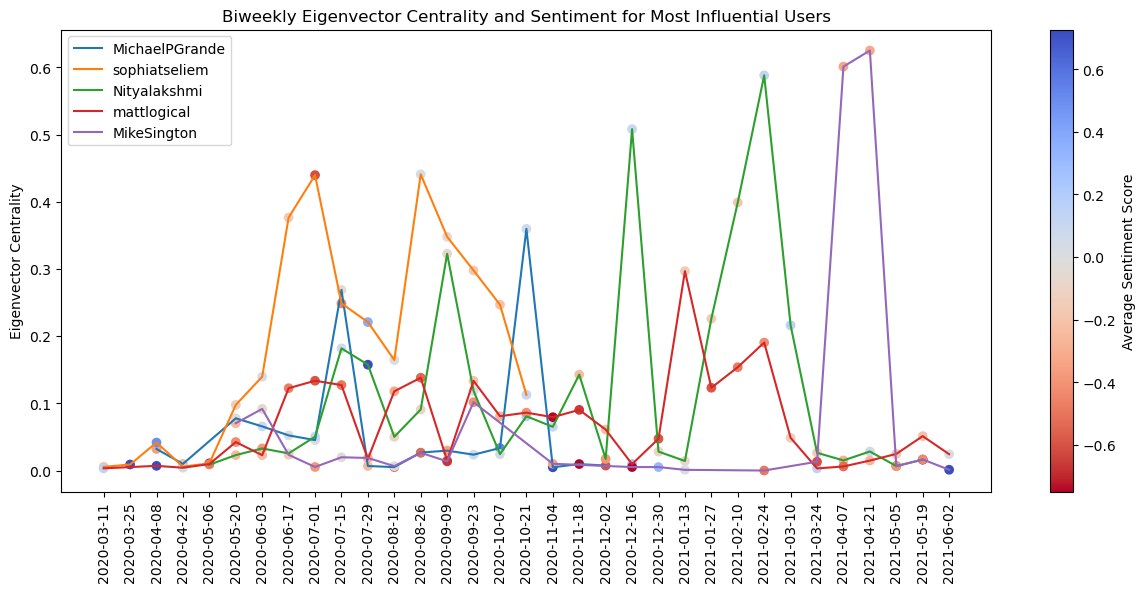

In [133]:
plt.figure(figsize=(15,6))
dates = [str(date)[:10] for date in biweekly_dates[:-1]]
dates = np.array([datetime.strptime(date, '%Y-%m-%d') for date in dates])
plt.xticks(dates) 

for user in user_centrs.keys():
    if user in list(top_5_users['user'][:5]):
        centrs = np.array(user_centrs[user])
        sents = np.array(user_sents[user])
        screen_name = df[df['user_id'] == user].iloc[0]['screen_name']

        mask = ~np.isnan(np.array(centrs))
        
        plt.plot(dates[mask], centrs[mask], label=f'{screen_name}')
        plt.scatter(dates, centrs, c=sents, cmap='coolwarm_r')

colorbar = plt.colorbar()
colorbar.set_label('Average Sentiment Score')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('Biweekly Eigenvector Centrality and Sentiment for Most Influential Users')
plt.legend()
plt.show()

In [136]:
userlist = list(top_5_users['user'][:5])
screenlist = list(top_5_users['screen name'][:5])

In [137]:
userlist, screenlist

([199120695, 59047876, 2185190036, 2234760798, 37039868],
 ['Nityalakshmi',
  'sophiatseliem',
  'mattlogical',
  'MikeSington',
  'MichaelPGrande'])

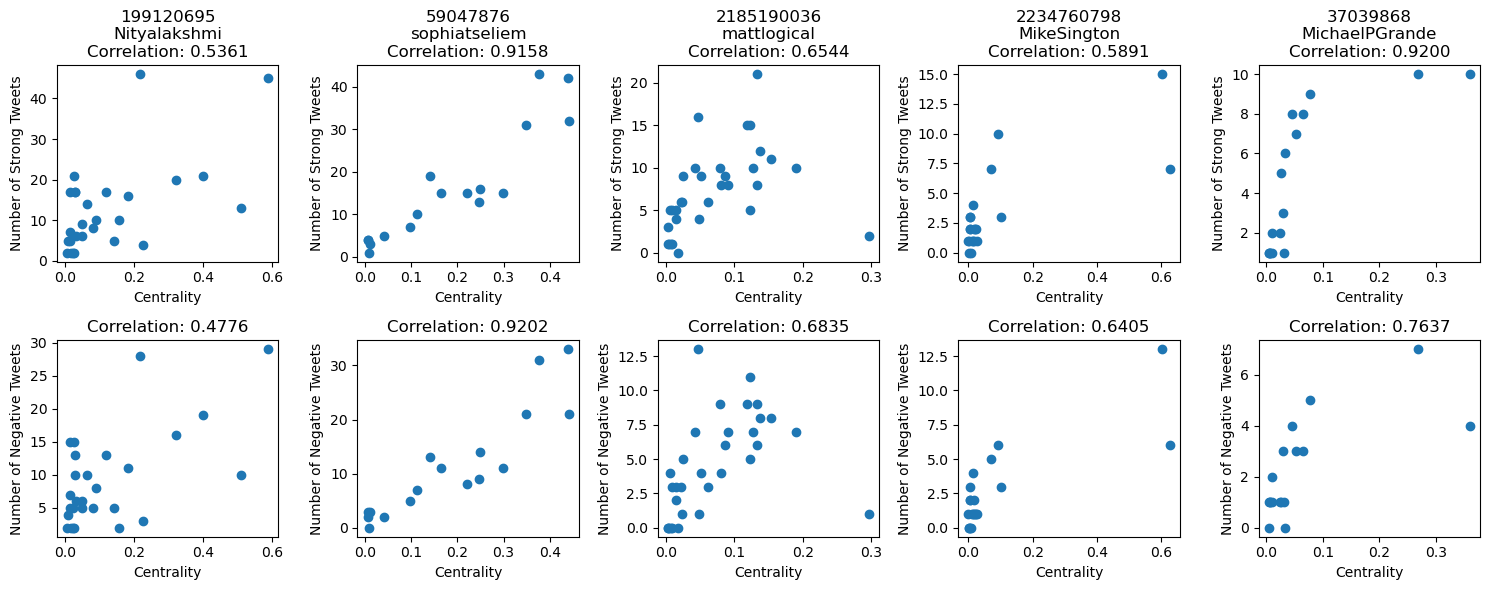

In [145]:
fig, ax = plt.subplots(2, 5, figsize=(15,6))

for i in range(5):
    user_id = userlist[i]
    centrs = user_centrs[user_id]
    avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)
    
    centrs, num_strong_tweets, num_negative_tweets = np.array(centrs), np.array(num_strong_tweets), np.array(num_negative_tweets)
    not_nan = ~np.isnan(centrs)
    centrs = centrs[not_nan]
    num_strong_tweets = num_strong_tweets[not_nan]
    num_negative_tweets = num_negative_tweets[not_nan]
    
    scatter1 = ax[0, i].scatter(centrs, num_strong_tweets)
    scatter2 = ax[1, i].scatter(centrs, num_negative_tweets)
    
    correlation1, _ = stats.spearmanr(centrs, num_strong_tweets)
    correlation2, _ = stats.spearmanr(centrs, num_negative_tweets)
    
    ax[0, i].set_title(f"{userlist[i]}\n{screenlist[i]}\nCorrelation: {correlation1:.4f}")
    ax[1, i].set_title(f"Correlation: {correlation2:.4f}")
    
    ax[0, i].set_xlabel('Centrality')
    ax[0, i].set_ylabel('Number of Strong Tweets')
    
    ax[1, i].set_xlabel('Centrality')
    ax[1, i].set_ylabel('Number of Negative Tweets')
    
plt.tight_layout()
plt.show()

In [147]:
top_5_users['user'][:5]

448     199120695
285      59047876
733    2185190036
735    2234760798
214      37039868
Name: user, dtype: int64

In [156]:
top_5_users

user  eigenvector centrality  weighted degree  num tweets  \
448           199120695                0.297871      8053.441088         417   
285            59047876                0.329947      9518.461504         405   
733          2185190036                0.223639      5967.849716         371   
735          2234760798                0.114745      3185.769852         104   
214            37039868                0.111720      2966.719364         142   
574           473384312                0.128157      3208.616266         120   
952  899404385700073472                0.095212      2530.337400         125   
823          3133488306                0.078231      2189.337314         111   
453           205240369                0.144378      3537.263125         102   
750          2323052250                0.101641      2612.390572         116   

     followers      screen name          prod  average sent  \
448        885     Nityalakshmi  7.127295e+06     -0.223182   
285        163    sophiatseliem  1.551509e+06     -0.191473   
733       1254      mattlogical  7.483684e+06     -0.079958   
735      17869      MikeSington  5.692652e+07     -0.234722   
214      10411   MichaelPGrande  3.088652e+07     -0.017851   
574        683  dandlionalchemy  2.191485e+06      0.010796   
952       3439  IAmKrishanPatel  8.701830e+06     -0.140676   
823       9309      TassajaraRd  2.038054e+07      0.246568   
453        282   Progress_orDie  9.975082e+05      0.026492   
750       1789       Mudaship39  4.673567e+06     -0.204694   

     num strong tweets  prop strong tweets  num negative tweets  \
448                235            0.563549                  178   
285                142            0.350617                  123   
733                105            0.283019                   74   
735                 46            0.442308                   37   
214                 46            0.323944                   27   
574                 26            0.216667                   11   
952                 43            0.344000                   35   
823                 37            0.333333                    9   
453                 22            0.215686                    9   
750                 42            0.362069                   37   

     prop negative tweets         prod2  
448              0.426859  54656.425145  
285              0.303704  48542.882270  
733              0.199461  42579.956343  
735              0.355769  31191.485899  
214              0.190141  27444.273146  
574              0.091667  20945.711960  
952              0.280000  20605.111205  
823              0.081081  20008.012982  
453              0.088235  19969.431136  
750              0.318966  19566.729361

In [166]:
user_id = 37039868
centrs = user_centrs[user_id]
avg_folls, avg_friends, avg_statuses, avg_sents, num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = get_engagements(user_id)

In [167]:
avg_folls, avg_friends, avg_statuses, avg_sents, centrs = np.array(avg_folls), np.array(avg_friends), np.array(avg_statuses), np.array(avg_sents), np.array(centrs)
num_strong_tweets, num_negative_tweets, prop_strong_tweets, prop_negative_tweets = np.array(num_strong_tweets), np.array(num_negative_tweets), np.array(prop_strong_tweets), np.array(prop_negative_tweets)
not_nan = ~np.isnan(avg_folls)
avg_folls = avg_folls[not_nan]
avg_friends = avg_friends[not_nan]
avg_statuses = avg_statuses[not_nan]
avg_sents = avg_sents[not_nan]
centrs = centrs[not_nan]
num_strong_tweets = num_strong_tweets[not_nan]
num_negative_tweets = num_negative_tweets[not_nan]
prop_strong_tweets = prop_strong_tweets[not_nan]
prop_negative_tweets = prop_negative_tweets[not_nan]

centrs_diff = np.diff(centrs)
folls_diff = np.diff(avg_folls)
friends_diff = np.diff(avg_friends)
statuses_diff = np.diff(avg_statuses)
sents_diff = np.diff(avg_sents)
num_strong_tweets_diff = np.diff(num_strong_tweets)
num_negative_tweets_diff = np.diff(num_negative_tweets)
prop_strong_tweets_diff = np.diff(prop_strong_tweets)
prop_negative_tweets_diff = np.diff(prop_negative_tweets)

centrs_prop = centrs[1:] / centrs[:-1]
folls_prop = avg_folls[1:] / avg_folls[:-1]
friends_prop = avg_friends[1:] / avg_friends[:-1]
statuses_prop = avg_statuses[1:] / avg_statuses[:-1]
sents_prop = np.abs(avg_sents[1:]) / np.abs(avg_sents[:-1])
num_strong_tweets_prop = num_strong_tweets[1:] / num_strong_tweets[:-1]
num_negative_tweets_prop = num_negative_tweets[1:] / num_negative_tweets[:-1]
prop_strong_tweets_prop = prop_strong_tweets[1:] / prop_strong_tweets[:-1]
prop_negative_tweets_prop = prop_negative_tweets[1:] / prop_negative_tweets[:-1]

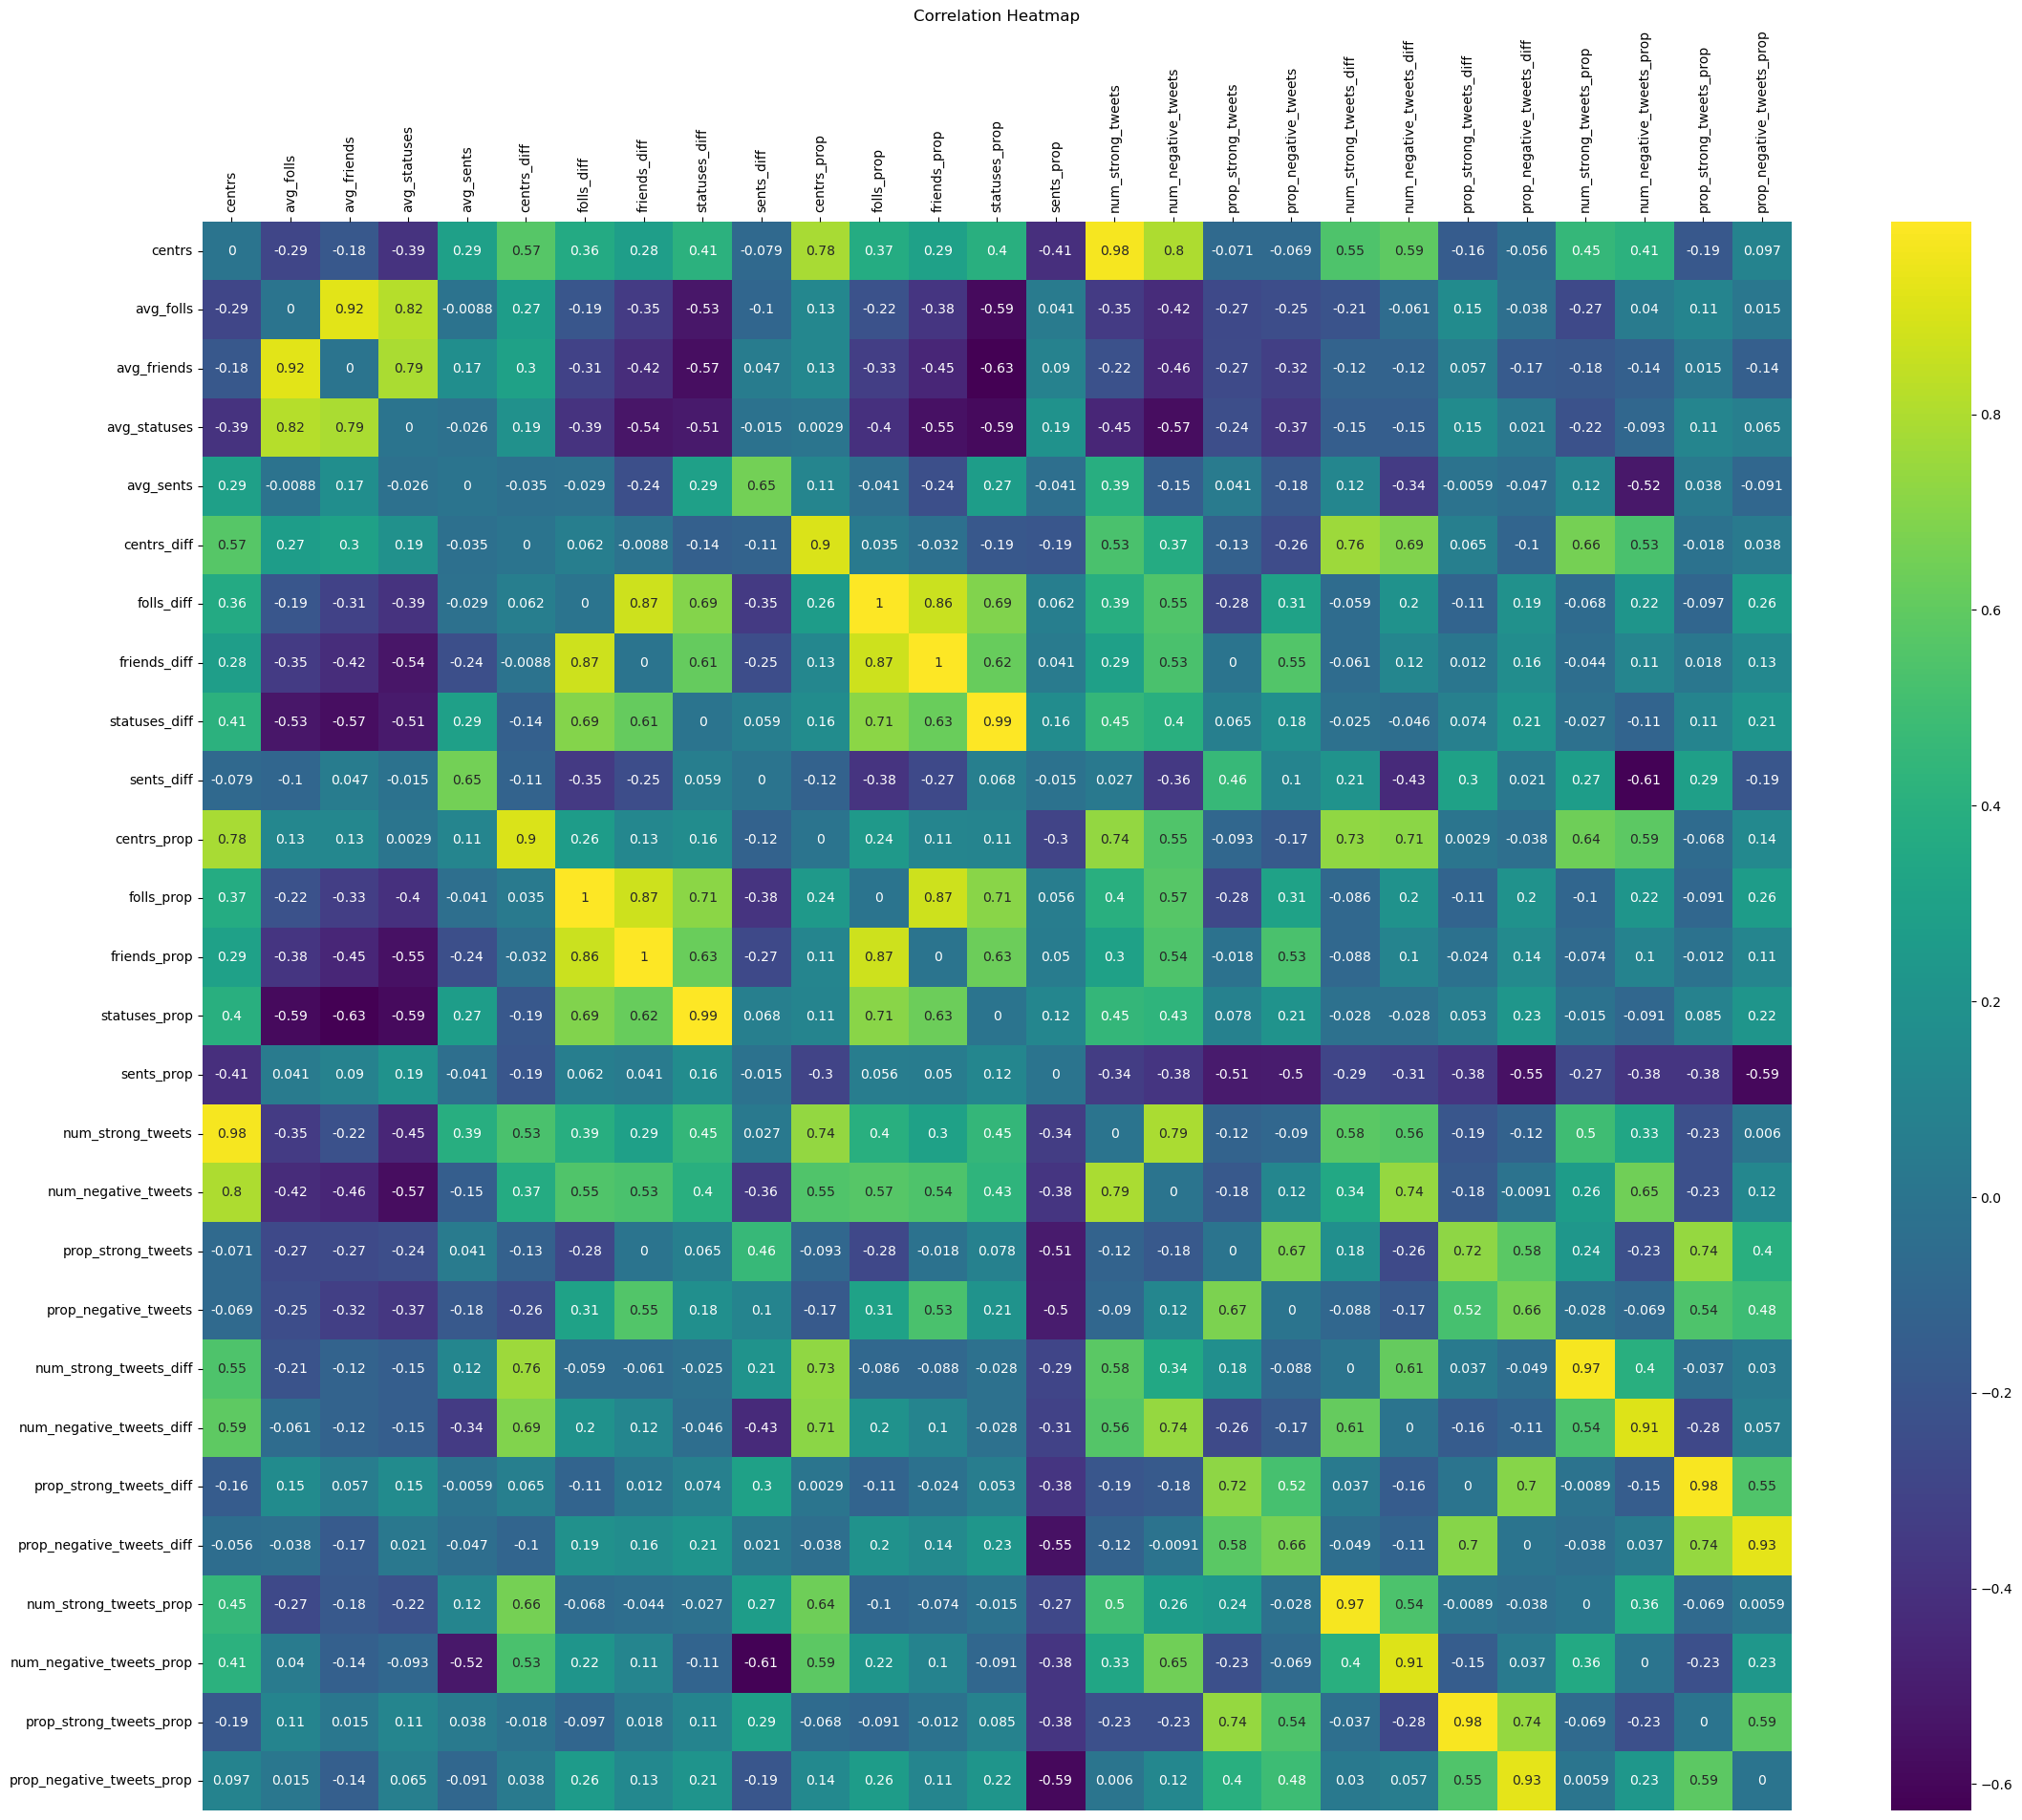

In [168]:
lists = [centrs[1:], avg_folls[1:], avg_friends[1:], avg_statuses[1:], avg_sents[1:], 
         centrs_diff, folls_diff, friends_diff, statuses_diff, sents_diff, 
         centrs_prop, folls_prop, friends_prop, statuses_prop, sents_prop, 
         num_strong_tweets[1:], num_negative_tweets[1:], prop_strong_tweets[1:], prop_negative_tweets[1:],
         num_strong_tweets_diff, num_negative_tweets_diff, prop_strong_tweets_diff, prop_negative_tweets_diff,
         num_strong_tweets_prop, num_negative_tweets_prop, prop_strong_tweets_prop, prop_negative_tweets_prop]

labels = ['centrs', 'avg_folls', 'avg_friends', 'avg_statuses', 'avg_sents', 
          'centrs_diff', 'folls_diff', 'friends_diff', 'statuses_diff', 'sents_diff', 
          'centrs_prop', 'folls_prop', 'friends_prop', 'statuses_prop', 'sents_prop',
          'num_strong_tweets', 'num_negative_tweets', 'prop_strong_tweets', 'prop_negative_tweets',
          'num_strong_tweets_diff', 'num_negative_tweets_diff', 'prop_strong_tweets_diff', 'prop_negative_tweets_diff',
          'num_strong_tweets_prop', 'num_negative_tweets_prop', 'prop_strong_tweets_prop', 'prop_negative_tweets_prop']

fig = plot2(lists, labels)

## Centrality change over Time, with `/usersby2w-black/`

In [467]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy import stats
import seaborn as sns
import warnings
from datetime import datetime
import matplotlib.dates as mdates

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [468]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')

In [469]:
df_c = pd.read_csv('./user networks/user_network_black.csv')

In [470]:
df_c.columns

Index(['user', 'eigenvector centrality', 'weighted degree', 'num tweets',
       'followers', 'screen name', 'average sent', 'num strong tweets',
       'num negative tweets', 'prop strong tweets', 'prop negative tweets',
       'prod', 'logprod'],
      dtype='object')

In [471]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

In [472]:
path = './usersby2w-black/user_network_'

user_centrs = {}
user_degrees = {}
user_sents = {}

for user in tqdm(list(df_c['user'])):
    centrs = []
    degrees = []
    sents = []
    for date in biweekly_dates[:-1]:
        df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
        try:
            centrs.append(df_date[df_date['user'] == user]['eigenvector centrality'].iloc[0])
            degrees.append(df_date[df_date['user'] == user]['weighted degree'].iloc[0])
            sents.append(df_date[df_date['user'] == user]['average sent'].iloc[0])
        except:
            centrs.append(np.nan)
            degrees.append(np.nan)
            sents.append(np.nan)
    user_centrs[user] = centrs 
    user_degrees[user] = degrees
    user_sents[user] = sents

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1195/1195 [00:54<00:00, 21.94it/s]


In [473]:
top_10_users = df_c.sort_values(by='logprod', ascending=False).iloc[:10]

In [474]:
top_10_users['influence'] = top_10_users['eigenvector centrality'] * np.log1p(top_10_users['followers'])

In [475]:
top_10_users = top_10_users.sort_values(by='influence', ascending=False).iloc[:10]

In [476]:
top_10_users

user  eigenvector centrality  weighted degree  num tweets  \
1            199120695                0.297871      8053.441088         417   
0             59047876                0.329947      9518.461504         405   
2           2185190036                0.223639      5967.849716         371   
6           2234760798                0.114745      3185.769852         104   
7             37039868                0.111720      2966.719364         142   
5            473384312                0.128157      3208.616266         120   
3            205240369                0.144378      3537.263125         102   
13  899404385700073472                0.095212      2530.337400         125   
11          2323052250                0.101641      2612.390572         116   
17          3133488306                0.078231      2189.337314         111   

    followers      screen name  average sent  num strong tweets  \
1         885     Nityalakshmi     -0.223182                235   
0         163    sophiatseliem     -0.191473                142   
2        1254      mattlogical     -0.079958                105   
6       17869      MikeSington     -0.234722                 46   
7       10411   MichaelPGrande     -0.017851                 46   
5         683  dandlionalchemy      0.010796                 26   
3         282   Progress_orDie      0.026492                 22   
13       3439  IAmKrishanPatel     -0.140676                 43   
11       1789       Mudaship39     -0.204694                 42   
17       9309      TassajaraRd      0.246568                 37   

    num negative tweets  prop strong tweets  prop negative tweets  \
1                   178            0.563549              0.426859   
0                   123            0.350617              0.303704   
2                    74            0.283019              0.199461   
6                    37            0.442308              0.355769   
7                    27            0.323944              0.190141   
5                    11            0.216667              0.091667   
3                     9            0.215686              0.088235   
13                   35            0.344000              0.280000   
11                   37            0.362069              0.318966   
17                    9            0.333333              0.081081   

            prod       logprod  influence  
1   7.127295e+06  54656.425145   2.021568  
0   1.551509e+06  48542.882270   1.682686  
2   7.483684e+06  42579.956343   1.595643  
6   5.692652e+07  31191.485899   1.123456  
7   3.088652e+07  27444.273146   1.033489  
5   2.191485e+06  20945.711960   0.836605  
3   9.975082e+05  19969.431136   0.815078  
13  8.701830e+06  20605.111205   0.775334  
11  4.673567e+06  19566.729361   0.761289  
17  2.038054e+07  20008.012982   0.714943

In [482]:
list(top_10_users['user'])[:5]

[199120695, 59047876, 2185190036, 2234760798, 37039868]

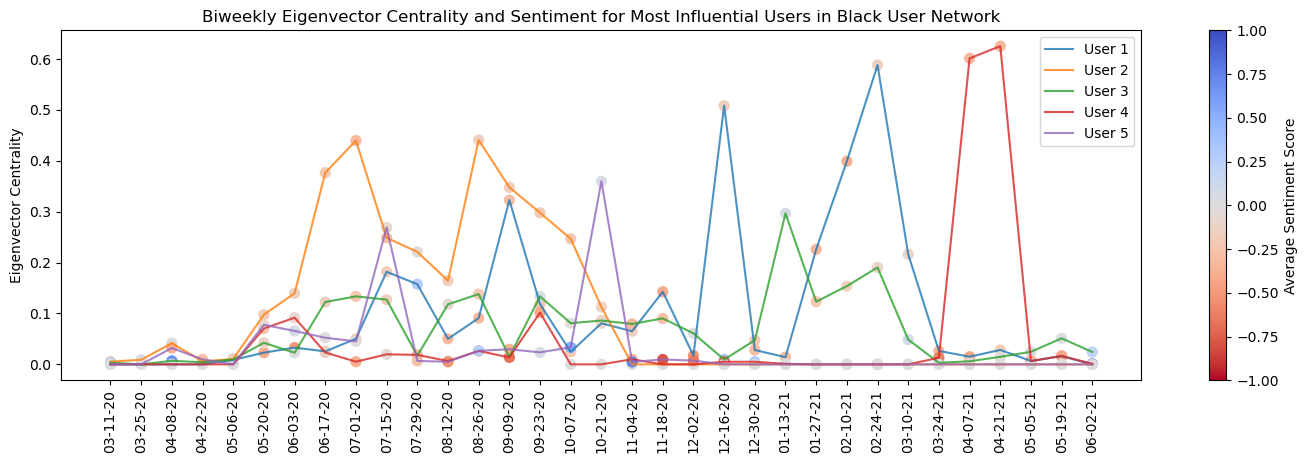

In [505]:
plt.figure(figsize=(15,5))
dates = [str(date)[:10] for date in biweekly_dates[:-1]]
dates = np.array([datetime.strptime(date, '%Y-%m-%d') for date in dates])
plt.xticks(dates) 

cmap = plt.get_cmap('coolwarm_r')
norm = plt.Normalize(-1, 1)

# for user in user_centrs.keys():
for i, user in enumerate(list(top_10_users['user'])[:5]):
    centrs = np.array(user_centrs[user])
    sents = np.array(user_sents[user])
    screen_name = df[df['user_id'] == user].iloc[0]['screen_name']
    idx = list(top_10_users['user'][:5]).index(user)

    # mask = ~np.isnan(np.array(centrs))

    plt.plot(np.nan_to_num(dates), np.nan_to_num(centrs), label=f'User {i+1}', alpha=0.8)
    plt.scatter(dates, np.nan_to_num(centrs), c=np.nan_to_num(sents), cmap=cmap, norm=norm, s=50)

colorbar = plt.colorbar()
colorbar.set_label('Average Sentiment Score')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('Biweekly Eigenvector Centrality and Sentiment for Most Influential Users in Black User Network')
plt.legend()
plt.subplots_adjust(left=0.1, right=1.0, top=0.9, bottom=0.2)
plt.savefig('./saves/cent time black.svg', format='svg')
plt.show()

## Centrality change over Time, with `/usersby2w-lgbtq/`

In [506]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy import stats
import seaborn as sns
import warnings
from datetime import datetime
import matplotlib.dates as mdates

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [507]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')

In [508]:
df_c = pd.read_csv('./user networks/user_network_lgbtq.csv')

In [509]:
df_c.columns

Index(['user', 'eigenvector centrality', 'weighted degree', 'num tweets',
       'followers', 'screen name', 'average sent', 'num strong tweets',
       'num negative tweets', 'prop strong tweets', 'prop negative tweets',
       'prod', 'logprod'],
      dtype='object')

In [510]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

In [ ]:
path = './usersby2w-lgbtq/user_network_'

user_centrs = {}
user_degrees = {}
user_sents = {}

for user in tqdm(list(df_c['user'])):
    centrs = []
    degrees = []
    sents = []
    for date in biweekly_dates[:-1]:
        df_date = pd.read_csv(path + f'{str(date)[:10]}.csv')
        try:
            centrs.append(df_date[df_date['user'] == user]['eigenvector centrality'].iloc[0])
            degrees.append(df_date[df_date['user'] == user]['weighted degree'].iloc[0])
            sents.append(df_date[df_date['user'] == user]['average sent'].iloc[0])
        except:
            centrs.append(np.nan)
            degrees.append(np.nan)
            sents.append(np.nan)
    user_centrs[user] = centrs 
    user_degrees[user] = degrees
    user_sents[user] = sents

 48%|████████████████████████████████████████████▉                                                 | 571/1195 [00:28<00:29, 21.40it/s]

In [ ]:
top_10_users = df_c.sort_values(by='logprod', ascending=False).iloc[:10]

In [ ]:
top_10_users['influence'] = top_10_users['eigenvector centrality'] * np.log1p(top_10_users['followers'])

In [ ]:
top_10_users = top_10_users.sort_values(by='influence', ascending=False).iloc[:10]

In [ ]:
top_10_users

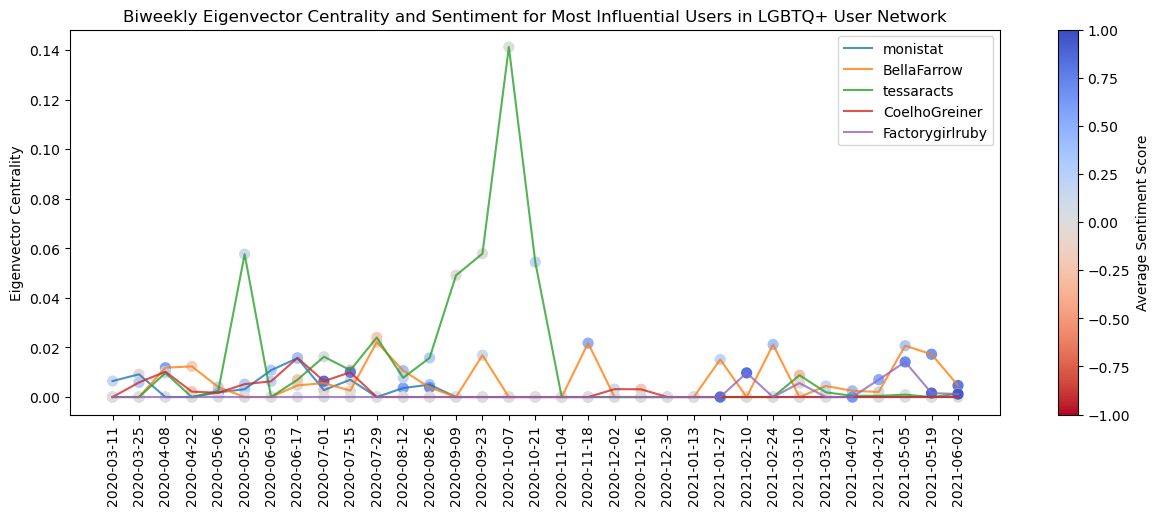

In [466]:
plt.figure(figsize=(15,5))
dates = [str(date)[:10] for date in biweekly_dates[:-1]]
dates = np.array([datetime.strptime(date, '%Y-%m-%d') for date in dates])
plt.xticks(dates) 

cmap = plt.get_cmap('coolwarm_r')
norm = plt.Normalize(-1, 1)

# for user in user_centrs.keys():
for i, user in enumerate(list(top_10_users['user'])[:5]):
    centrs = np.array(user_centrs[user])
    sents = np.array(user_sents[user])
    screen_name = df[df['user_id'] == user].iloc[0]['screen_name']
    idx = list(top_10_users['user'][:5]).index(user)

    # mask = ~np.isnan(np.array(centrs))

    plt.plot(np.nan_to_num(dates), np.nan_to_num(centrs), label=f'User {i+1}', alpha=0.8)
    plt.scatter(dates, np.nan_to_num(centrs), c=np.nan_to_num(sents), cmap=cmap, norm=norm, s=50)

colorbar = plt.colorbar()
colorbar.set_label('Average Sentiment Score')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
plt.xticks(rotation=90)
plt.ylabel('Eigenvector Centrality')
plt.title('Biweekly Eigenvector Centrality and Sentiment for Most Influential Users in LGBTQ+ User Network')
plt.legend()
plt.subplots_adjust(left=0.1, right=1.0, top=0.9, bottom=0.2)
plt.savefig('./saves/cent time lgbtq.svg', format='svg')
plt.show()